# Assignment 3 - COSC102 - T2 - 2023

## Authors:
- Beau Salwin - STUDENT ID TODO - (bsalwin@myune.edu.au)
- Kim Wong - 220263996 - (kwong48@myune.edu.au)
- Lucas Fonseca Martins - 220242871 - (lfonseca@myune.edu.au)

## Objectives
1. Enhance problem-solving capabilities using Python and its modules in a collaborative environment.
2. Develop a comprehensive machine learning portfolio that meticulously outlines the workflow from data preprocessing to model evaluation.
3. Implement a machine learning model for classifying activities like walking, running, or standing based on data from inertial sensors.
4. Engage in a thorough comparison of various machine learning algorithms to determine their effectiveness for the task at hand.
5. Develop insightful visualizations that represent the decision boundaries and the learning aspects of the trained machine learning classifiers.

## Background
Mobile devices, including smartphones and smartwatches, utilize inertial sensors to classify activities in real-time, assisting users in tracking their daily activities and performance metrics. Machine learning offers a promising avenue for these classification tasks, with several algorithms demonstrating robust performance.

For this assignment, we will work with a dataset obtained from an inertial sensor (MPU-9250 IMU data logger). The workflow involves processing this dataset, visualizing its features, and employing various machine learning algorithms to assess their efficiency in activity classification.

## Dataset Overview

We will work with three core datasets:

- **Raw IMU Dataset**: Captured at 100 samples/second using a custom MPU-9250 IMU data logger. This CSV file encompasses 7 columns detailing the timestamp, x, y, and z-axis acceleration, and gyroscope readings.
- **Activity Annotation File**: This is a CSV file that marks the commencement of various activities during the data capture session.
- **Activity Annotation Video**: A video recording meant for reviewing purposes, assisting in aligning the IMU dataset with the annotation file.

## Activity Classification
Using the data acquired from the MPU-9250 IMU sensor, the primary objective is to classify the detected motion into one of the five predefined categories:

- Standing
- Walking
- Jogging
- Side-Step
- Running

This classification is pivotal as it will allow us to understand and analyze the exact movements and transitions of the subject based on the recorded inertial sensor data.

### Importing the libraries

We first start importing the libraries we will use.

In [1]:
# Standard Libraries
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Model Selection and Hyperparameter Tuning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_val_predict
from sklearn.feature_selection import RFECV

# Metrics and Evaluation
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, recall_score,
                             precision_score, f1_score, accuracy_score, classification_report,
                             roc_curve, auc, ConfusionMatrixDisplay)

# Visualization for Decision Trees
from dtreeviz.trees import *

# Partial Dependence Plots
from sklearn.inspection import partial_dependence

# CSV File
import csv

# Math and Statistics
import math
import statistics 

# Data Manipulation
import pandas as pd

### Definitions

- `imu_data_file`: This file will contain readings from the MPU-9250 IMU data logger.
- `activity_annotations_data_file`: This file contains timestamps or markers indicating when a specific activity (like walking, jogging, etc.) started.
- `video_length`: It represents the duration of the associated video in seconds. This video is used as a reference to help align the IMU data with the activity annotations.


In [2]:
# Defines
imu_data_file = 'a3_imu_data.csv'
activity_annotations_data_file = 'a3_activity_annotations.csv'
video_length = 711 # seconds

### Lists

This section of code is setting up lists to store different pieces of IMU (Inertial Measurement Unit) data as the program processes the data.

- `time_track`: This list is intended to store the timestamps or time points when each data sample was taken. Each entry in this list represents a unique time at which IMU readings were captured.

- `ax_set`, `ay_set`, and `az_set`: These lists are for storing the acceleration data in the x, y, and z axes, respectively. In other words, as the IMU captures acceleration data over time, these lists will hold the respective x, y, and z values for that data.

- `gx_set`, `gy_set`, and `gz_set`: Similarly, these lists are for storing the gyroscope data (angular velocity) in the x, y, and z axes, respectively. As the IMU captures gyroscopic data over time, these lists will hold the corresponding x, y, and z values.

- `activity_set`: This list is designed to store the activity labels or annotations corresponding to each timestamp. For instance, at a particular time, the subject might be "Walking" or "Running," and this list will store that information.

In [3]:
# Set the lists to store the IMU data

time_track = []
ax_set = []
ay_set = []
az_set = []

gx_set = []
gy_set = []
gz_set = []

activity_set = []

### Activity Mapping

- `activity_mapping` is a dictionary that associates an activity description (a string) with a unique integer identifier.

- Function `map_activity`: This function takes in an activity description (a string like 'Walking' or 'Jogging') and returns its corresponding integer identifier using the `activity_mapping`.

- Function `get_activity_list`: This function returns a list of all activities in order according to their mapped integer values.

In [4]:
activity_mapping = {
        'Standing': 0,
        'Walking': 1,
        'Jogging': 2,
        'Side-Step': 3,
        'Running': 4
    }

def map_activity(activity_string):
    """
    Maps a given activity string to a corresponding integer value.

    The following mappings are used:
        'Standing'   -> 0
        'Walking'    -> 1
        'Jogging'    -> 2
        'Side-Step'  -> 3
        'Running'    -> 4

    :param activity_string: A string representing the activity.
    :return: An integer corresponding to the given activity, or None if the activity string is not recognized.
    """
    return activity_mapping.get(activity_string, None)

def get_activity_list():
    """
    Returns a list of activities in order according to their mapped values.

    :return: A list of activities.
    """
    activity_list = [None] * len(activity_mapping)
    for activity, value in activity_mapping.items():
        activity_list[value] = activity

    return activity_list

### Reading IMU data file and populating the lists

We now open the CSV file contaning the IMU data and populate the lists: time_track, a(x/y/z)_set, and g(x/y/z)_set.

In [5]:
# Define the fields/column names in the IMU data file

fields = ['time', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']

# Open the CSV file containing the IMU data
with open(imu_data_file, newline='') as f:
    reader = csv.DictReader(f, fieldnames=fields)
    for row in reader:
        #print(row)
        time_track.append(float(row['time']))
        ax_set.append(float(row['ax']))
        ay_set.append(float(row['ay']))
        az_set.append(float(row['az']))
        gx_set.append(float(row['gx']))
        gy_set.append(float(row['gy']))
        gz_set.append(float(row['gz']))

### Visualizing the IMU Data and Identifying the Starting Point
The provided code snippet is designed to visualize the Inertial Measurement Unit (IMU) data, ensuring its accuracy and consistency.

#### Identifying the Starting Point
We need to pinpoint the exact starting point of the data, which aligns with the commencement of the video. Based on the video, we know that the initial activity is *walking*, and we are aware of some noise at the beginning (due to camera setup and a brief *standing* period).

To address this challenge, we plotted the IMU data as broadly as feasible and incorporated ticks at intervals of 200, with appropriate labels.

From this visualization, we can approximate that the starting point aligns closely with the **901** timestamp.

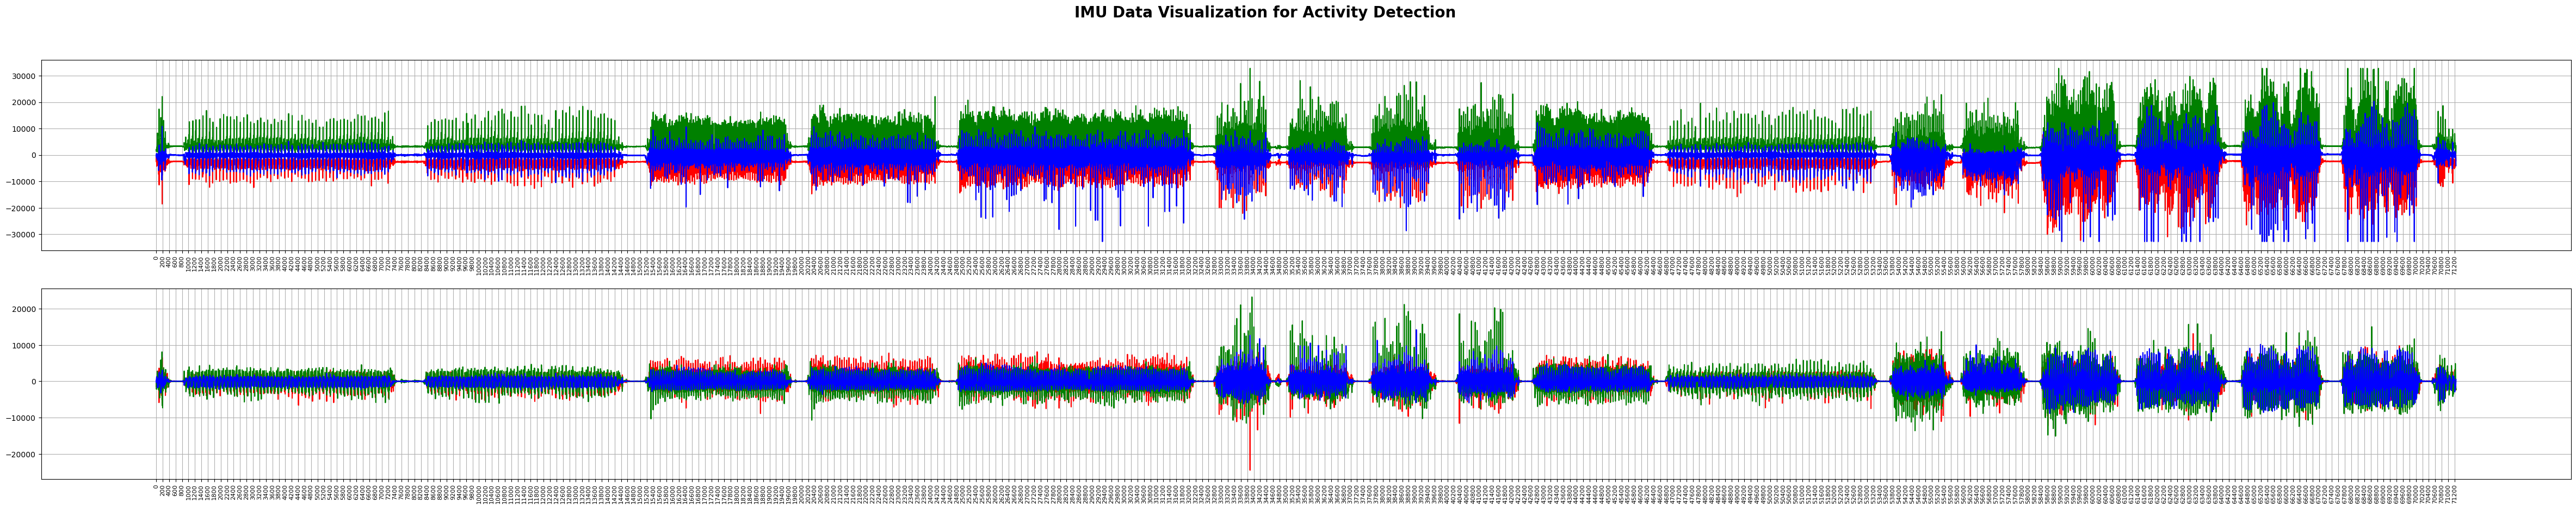

In [6]:
# Visualize the IMU data to determine the start index of the first step

fig, axs = plt.subplots(2,1,figsize=(60,10))

# Adding the title here
fig.suptitle('IMU Data Visualization for Activity Detection', fontsize=20, fontweight='bold')

axs[0].plot(ax_set, color='r')
axs[0].plot(ay_set, color='g')
axs[0].plot(az_set, color='b')
axs[0].set_xticks(range(0, len(ax_set), 200)) # Add this line to set ticks at intervals of 200
axs[0].set_xticklabels(axs[0].get_xticks(), rotation=90, fontsize=8) # Rotate the labels by 90 degrees
axs[0].grid(True)  # Add grid to first subplot

axs[1].plot(gx_set, color='r')
axs[1].plot(gy_set, color='g')
axs[1].plot(gz_set, color='b')
axs[1].set_xticks(range(0, len(gx_set), 200)) # Add this line to set ticks at intervals of 200
axs[1].set_xticklabels(axs[1].get_xticks(), rotation=90, fontsize=8) # Rotate the labels by 90 degrees
axs[1].grid(True)  # Add grid to first subplot

start_idx = 901 # by observation

#### Sanity check - Start Point
We plot again but now starting from `start_idx`.

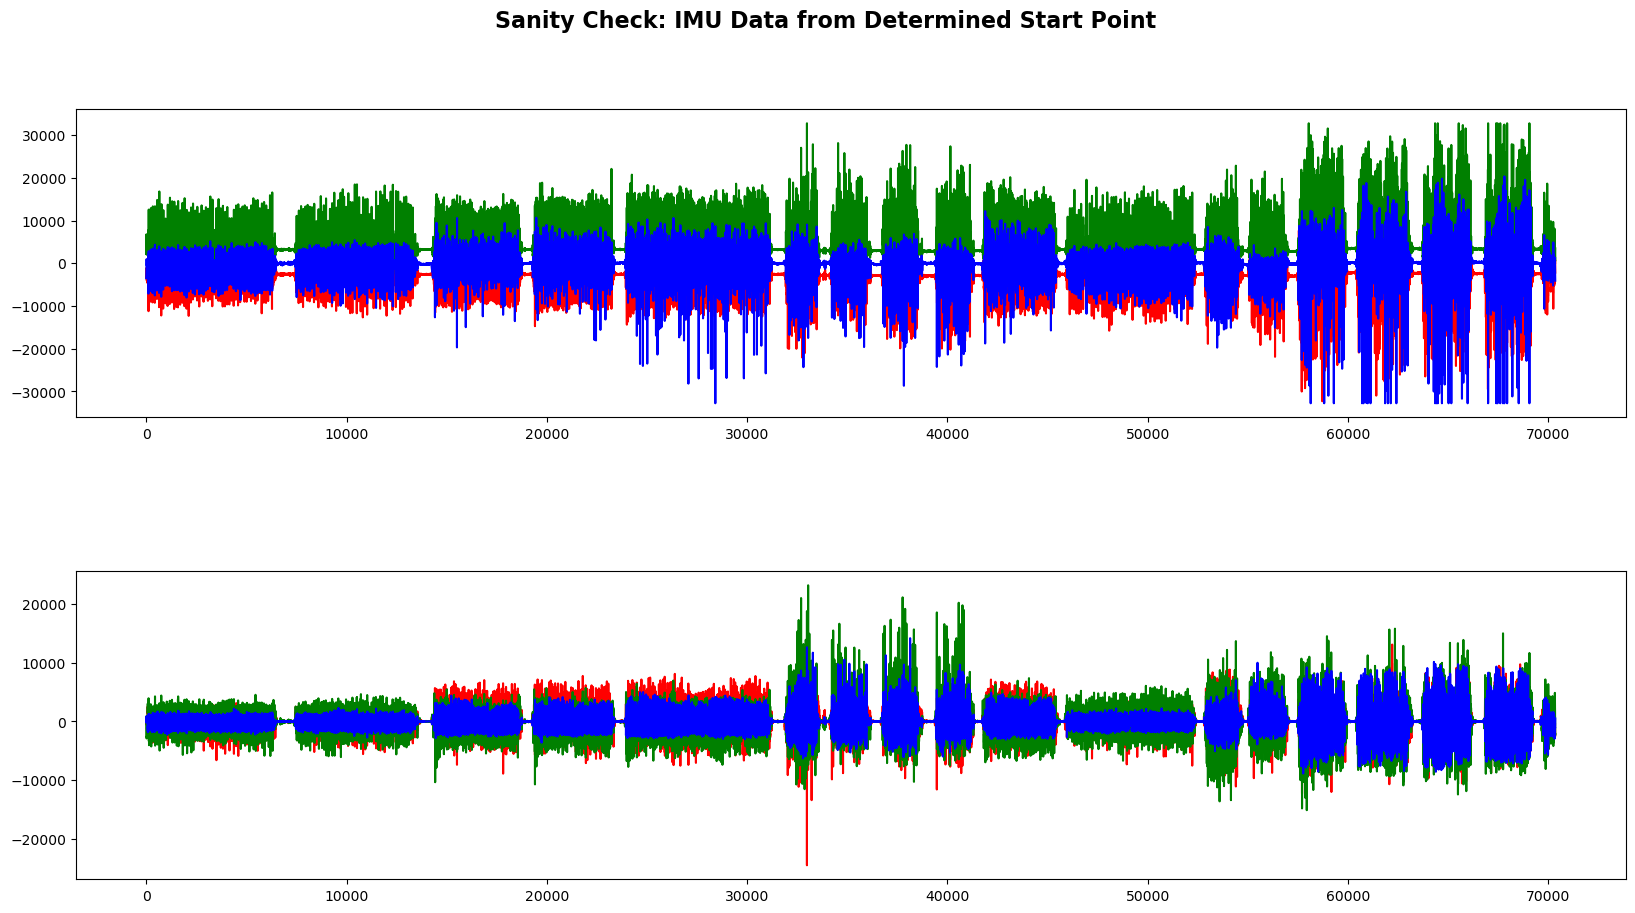

In [7]:
# Sanity check for the data - start point

fig, axs = plt.subplots(2,1,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Sanity Check: IMU Data from Determined Start Point', fontsize=16, fontweight='bold')

axs[0].plot(ax_set[start_idx:], color='r')
axs[0].plot(ay_set[start_idx:], color='g')
axs[0].plot(az_set[start_idx:], color='b')

axs[1].plot(gx_set[start_idx:], color='r')
axs[1].plot(gy_set[start_idx:], color='g')
axs[1].plot(gz_set[start_idx:], color='b')

#### Identifying the End Point
Now that we have identified the starting point, we need to determine the end point. This can be achieved by using the start timestamp and the length of the video.

Based on the video information, we know the duration is 711 seconds and our starting index is 901.

To find the start timestamp, we retrieve the value from the `time_track` list.

Next, we add the video length to the start timestamp.

Finally, we search for the index in the `time_track` list that matches the end timestamp.

In [8]:
#Now we need to find the end point
start_ts = time_track[start_idx]
print(f"Start Time Stamp: {start_ts}")

# The video has been cut to 711 seconds in length - need to find 
# Start_ts + video_length seconds. This should land us at the end point.

end_ts = start_ts + video_length # timestamp of the end of the video

# We can find the index of the end point by finding the index of the
# timestamp closest to the end_ts
end_idx = time_track.index(start_ts + video_length)
print(f"End Time Stamp: {time_track[end_idx]}")



Start Time Stamp: 1598240222.0
End Time Stamp: 1598240933.0


#### Sanity check - Start Point to End Point
We plot again but now starting from `start_idx` and finishing at `end_idx`.

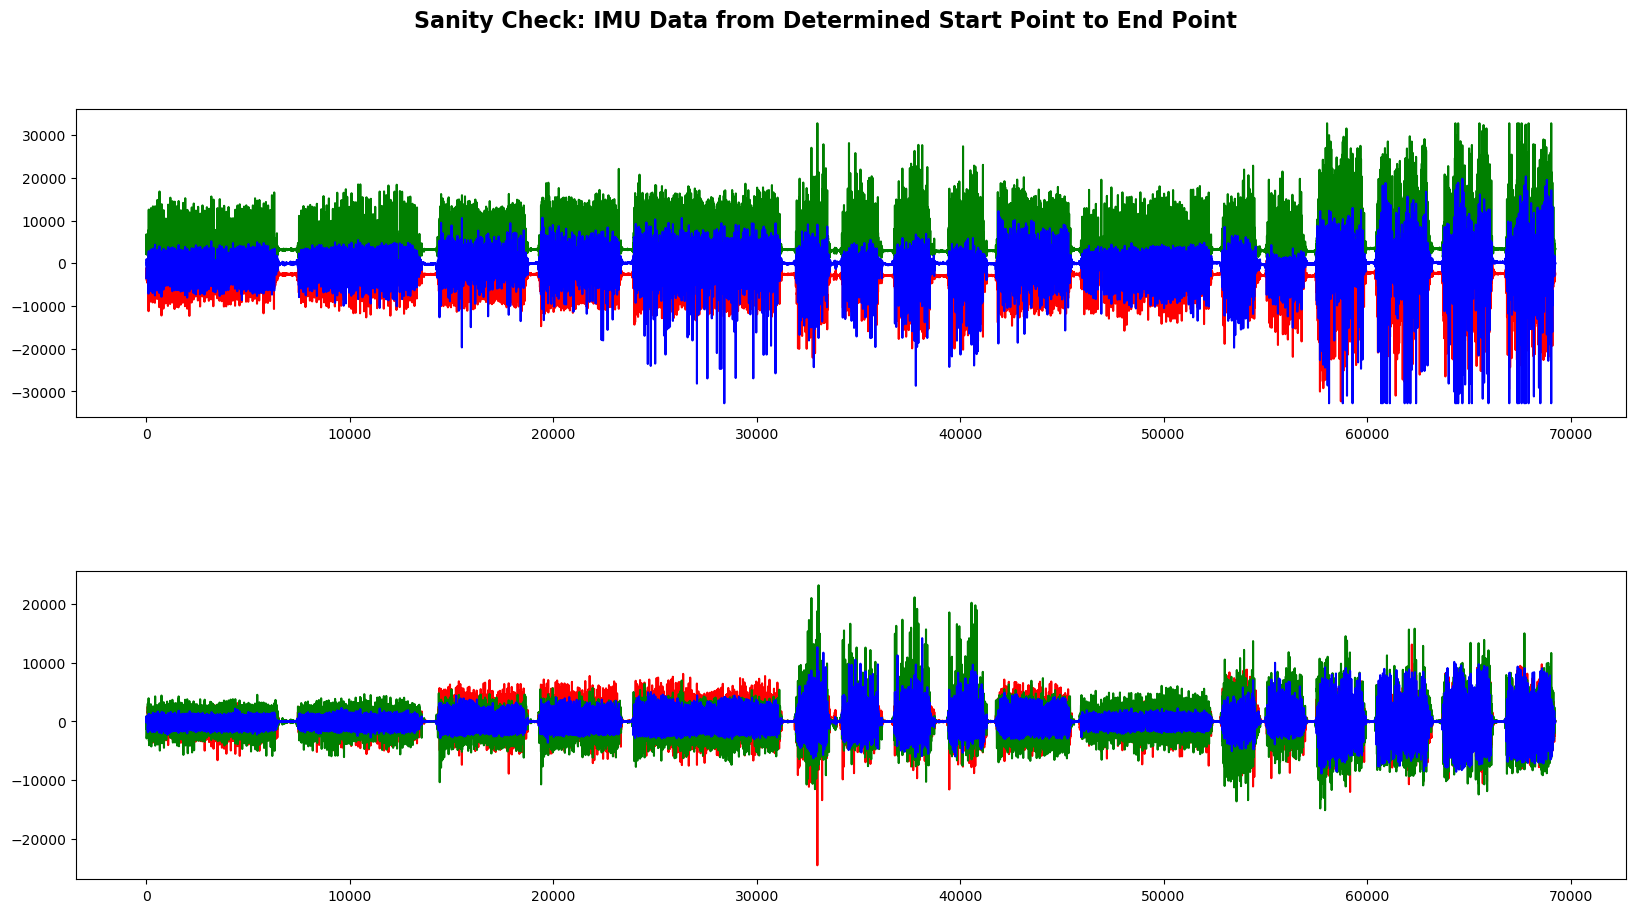

In [9]:
# Sanity check for the identified range (start to end)
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

fig.subplots_adjust(hspace=0.5)
fig.suptitle('Sanity Check: IMU Data from Determined Start Point to End Point', fontsize=16, fontweight='bold')

axs[0].plot(ax_set[start_idx:end_idx], color='r')
axs[0].plot(ay_set[start_idx:end_idx], color='g')
axs[0].plot(az_set[start_idx:end_idx], color='b')

axs[1].plot(gx_set[start_idx:end_idx], color='r')
axs[1].plot(gy_set[start_idx:end_idx], color='g')
axs[1].plot(gz_set[start_idx:end_idx], color='b')

### Reading Activity Annotations data file and populating the list

We now open the CSV file contaning the Activity Annotations and populate the list `activity_set`.

Then, we print a table of the populated list for sanity check.

In [10]:
# Read activity annotations CSV file and print the data in a table
with open(activity_annotations_data_file, 'r') as f:
    reader = csv.reader(f)
    next(reader, None)  # skip the headers
    for row in reader:
        time_Stamp = (row[0].split('='))[1]
        activity_set.append([float(time_Stamp), row[-1], map_activity(row[-1])])

# Determine the maximum length for activity column for dynamic padding
max_activity_length = max([len(entry[1]) for entry in activity_set]) if activity_set else 7  # 7 is the length of "Activity"

# Print the header of the table
print(f"{'Timestamp':<15} {'Activity':<{max_activity_length+2}} {'Code':<10}")
print('-' * (15 + max_activity_length + 2 + 10))

# Print the data rows
for entry in activity_set:
    if len(entry) != 3:
        print(f"Unexpected entry format: {entry}")
        continue
    timestamp, activity, code = entry
    print(f"{timestamp:<15.2f} {activity:<{max_activity_length+2}} {code:<10}")



Timestamp       Activity    Code      
------------------------------------
0.00            Walking     1         
66.20           Standing    0         
75.40           Walking     1         
139.33          Standing    0         
146.73          Jogging     2         
191.40          Standing    0         
197.20          Jogging     2         
239.47          Standing    0         
244.60          Jogging     2         
320.93          Standing    0         
328.00          Side-Step   3         
345.07          Standing    0         
351.53          Side-Step   3         
371.33          Standing    0         
376.73          Side-Step   3         
396.53          Standing    0         
403.53          Side-Step   3         
422.40          Standing    0         
426.93          Jogging     2         
466.87          Standing    0         
471.07          Walking     1         
538.13          Standing    0         
542.33          Side-Step   3         
561.07          Standing   

### Activity Time Track

We need to construct a time series of activities corresponding to the IMU (Inertial Measurement Unit) data points between the identified start and end times.

1. Two lists, activity_timeseries and activity_string_timeseries, are initialized. These lists will store the numerical codes and string descriptors, respectively, of activities at each IMU data point.
2. The code fetches the timestamp of the start point and identifies the relevant segment of the time track.
3. An 'end' activity is appended, essentially marking the end of the data with a 'Standing' activity. This helps in concluding the activity sequence.
4. The time track segment is adjusted by subtracting the start time, making the IMU timestamps consistent with the video's timeline.

#### Plot the time series

We then plot the IMU data as before, and at the beginning of each new activity, we draw a line. By doing this, we can verify if our IMU and activity annotations are aligned. Since we know that the 'standing' activity should appear more or less as a straight line, we can visually detect changes in activities.

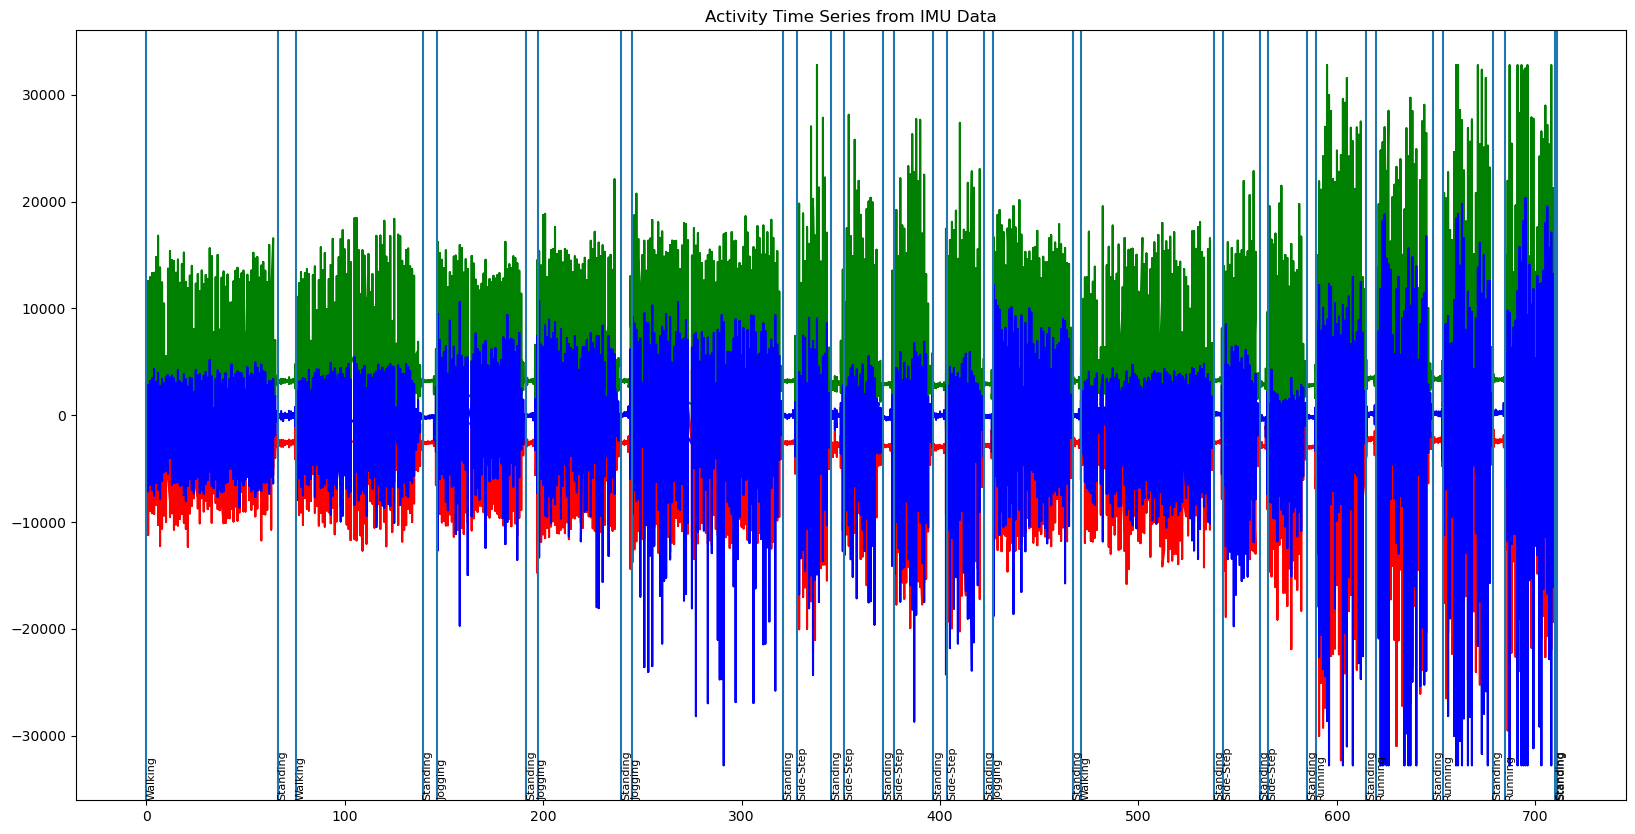

In [11]:
# Set up the list of activities
activity_timeseries = []
activity_string_timeseries = []
activity_idx = 0

# We need the time stamp for the start point
start_time = time_track[start_idx]

# The time track segment we are interested in 
time_track_segment = time_track[start_idx:end_idx]

#Add an 'end' activity - this book-ends the data
activity_set.append([time_track_segment[-1]-start_time, 'Standing'])

# Zero out the time track segment to make it match the video time
time_track_segment = np.array(time_track_segment)-start_time

# Plot the time series
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Activity Time Series from IMU Data')  # Setting the title
ax.plot(time_track_segment,ax_set[start_idx:end_idx], color='r')
ax.plot(time_track_segment,ay_set[start_idx:end_idx], color='g')
ax.plot(time_track_segment,az_set[start_idx:end_idx], color='b')

for imu_time_track_item in time_track_segment:
    current_time =  imu_time_track_item
    next_activity_ts = activity_set[activity_idx+1][0]
    
    # Here we need to move to the next activity in the annotations data if the current
    # IMU data point lies after the next annotation time stamp.
    if current_time > next_activity_ts:
        # Move to next activity
        activity_idx = activity_idx + 1
        next_activity_ts = activity_set[activity_idx+1][0]
    
    activity_timeseries.append(activity_set[activity_idx][2])
    activity_string_timeseries.append(activity_set[activity_idx][1])

# Plot the location of the activity transitions and add labels
activity_times = np.array(list(zip(*activity_set)))[0,:]
activity_labels = np.array(list(zip(*activity_set)))[1,:]
for i, act_time in enumerate(activity_times):
    ax.axvline(float(act_time))
    ax.text(float(act_time), ax.get_ylim()[0], activity_labels[i], 
            rotation=90, va='bottom', ha='left', fontsize=8)  # Add label with 90-degree angle


#### Activity Distribution Visualization

In this visualization, we represent the distribution of different activities using a histogram. 

The histogram displays the frequency of each activity, allowing us to quickly ascertain the predominance of particular activities in the dataset.

Text(0.5, 1.0, 'Activity Distribution')

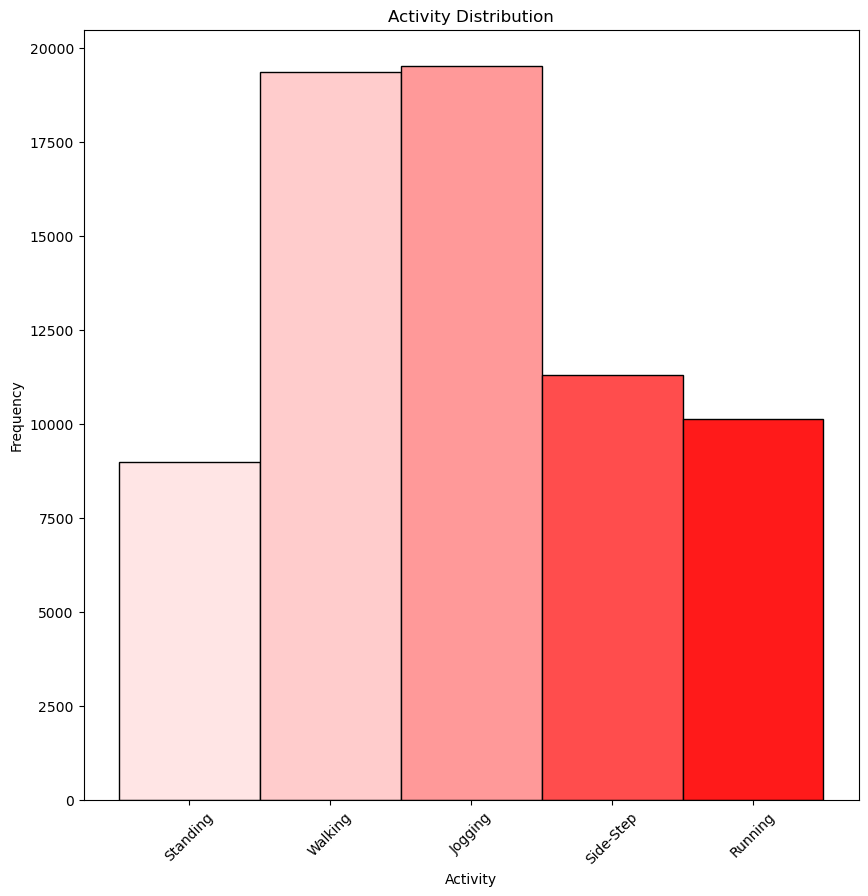

In [12]:
# Activity Distribution Plot
fig, ax = plt.subplots(figsize=(10,10))

# Define a list of reddish colors for each activity, from lighter to darker
colors = ['#ffe5e5', '#ffcccc', '#ff9999', '#ff4d4d', '#ff1a1a']

counts, bins, patches = ax.hist(
    activity_timeseries, 
    bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], 
    edgecolor='black')

# Color each patch (bar) based on the corresponding color
for i in range(len(patches)):
    patches[i].set_facecolor(colors[i])

# Label the bins with activity names
ax.set_xticks([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)])
ax.set_xticklabels(get_activity_list(), rotation=45)

# Add axis labels and title
ax.set_xlabel("Activity")
ax.set_ylabel("Frequency")
ax.set_title("Activity Distribution")

### Refiting the data

Now that we are confident that our start and end points are correct, we can adjust the IMU data to fit only the frame that corresponds to the video.

In [13]:
#We are only interested in the video window
ax_set = ax_set[start_idx:end_idx]
ay_set = ay_set[start_idx:end_idx]
az_set = az_set[start_idx:end_idx]
gx_set = gx_set[start_idx:end_idx]
gy_set = gy_set[start_idx:end_idx]
gz_set = gz_set[start_idx:end_idx]

### Constructing a Feature Set

Utilizing raw IMU data for activity classification might not produce optimal results when adopting a machine learning methodology. For a machine learning model to perform effectively in the domain of activity classification, it's essential to derive features from the raw data that encompass multiple time steps. By implementing a moving window strategy, you can compute a distinct set of features for every second in the IMU dataset. Potential features to consider are:

- Mean (for x, y, and z axes)
- Minimum (for x, y, and z axes)
- Maximum (for x, y, and z axes)
- The Signal Magnitude Area (for accelerometer and gyroscope)
- Average intensity (for accelerometer and gyroscope)

#### Moving Window

In essence, a moving window technique captures a specific, fixed duration from the time series and progressively shifts or "slides" this window across the entire data to extract features. As a starting point, we'll utilize a window duration of 1 second, ensuring there's no overlap between consecutive windows. This non-overlapping choice simplifies our initial approach, allowing us to gradually build upon it.

#### Missing Data Points

We've identified instances of missing data, likely attributed to a faulty segment on the SD card. Instead of disregarding the affected window, we'll opt to fill in these gaps using values from the preceding window, assuming they're available. While this isn't a perfect solution, it offers a more consistent approach than skipping the window entirely. Omitting these windows previously led to data misalignment, which in turn, adversely affected the performance of our classifier. By adopting this strategy, we aim to maintain data consistency and enhance classifier efficacy.


#### Mean, Minimum, and Maximum

For calculating the Mean, Minimum, and Maximum, we will leverage Python's built-in functions: `statistics.mean`, `max`, and `min`. We'll apply these functions on the data points within each 1-second frame, iterating through the *x*, *y*, and *z* coordinates.

#### The Signal Magnitude Area

The Signal Magnitude Area (SMA) is a measure that aggregates the magnitude of a multi-dimensional signal. For a three-dimensional signal like accelerometer data (x, y, z axes), the SMA is the sum of the absolute values of its components over a specified window. It provides an overall sense of the energy or intensity of the signal within that window.

To calculate that we use the formula:

$$
SMA = \frac{1}{T} \left( \sum_{t=1}^{T} |a_x(t)| + \sum_{t=1}^{T} |a_y(t)| + \sum_{t=1}^{T} |a_z(t)| \right)
$$

#### Average intensity

Average intensity refers to the mean value of a signal's magnitude over a specified period or window, representing the overall strength or level of the signal during that time.

To calculate that we use the formula:

$$
AI = \frac{1}{T} \sum_{t=1}^{T} \sqrt{a_x(t)^2 + a_y(t)^2 + a_z(t)^2}
$$

#### Features Set

Once we calculated all the values we add to a list of features that has the following order:

*Mean*
- [0] mu_ax 
- [1] mu_ay
- [2] mu_az
- [3] mu_gx
- [4] mu_gy
- [5] mu_gz

*Max*
- [6] max_ax
- [7] max_ay
- [8] max_az
- [9] max_gx
- [10] max_gy
- [11] max_gz

*Min*
- [12] min_ax
- [13] min_ay
- [14] min_az
- [15] min_gx
- [16] min_gy
- [17] min_gz

*Signal Magnitude Area*
- [18] a_sma 
- [19] g_sma

*Average intensity*
- [20] a_av_intensity
- [21] g_av_intensity

We then, for each 1 second frame append the list of values to `feature_set` and the correspondig activity to `target_set`.

In [14]:
# Now we can start working on the machine learning workflow.
# The first step is to calculate some feature that we can use.
# We will base our analysis around a moving window across the
# the timeseries data. This involves taking a fixed length window, based upon the time, and
# sliding it across the data.
# To keep thing simple, we will start with a 1 second window with no overlapping
# data points

feature_set = []
target_set  = []            
window_size = 1.0;         

# Save previous time to check for missing data
prev_window_start_idx = None
prev_window_end_idx = None

for t in range(int(time_track_segment[0]),int(time_track_segment[-1])):
    
    # There are missing data-points (probably due to a bad segment on the SD card)
    # Instead of skipping the window, we will use the previous window values (if they exist)
    # This is not ideal, but it is better than skipping the window, and it will not
    # have a large impact on the results.
    # Skipping the windows was causing the data to be misaligned, which was causing
    # the classifier to perform poorly.
    if t not in time_track_segment or t+window_size not in time_track_segment:
        print("Missing data-point at time: ", t)
        if prev_window_start_idx is not None:
            # Use the previous window
            window_start_idx = prev_window_start_idx
            window_end_idx = prev_window_end_idx
        else:
            continue
    else:
        #The index function finds the index of the first occurnace of the data
        window_start_idx = list(time_track_segment).index(t)
        window_end_idx = list(time_track_segment).index(t+window_size)
        prev_window_start_idx = window_start_idx
        prev_window_end_idx = window_end_idx

    ax_window = ax_set[window_start_idx:window_end_idx]
    ay_window = ay_set[window_start_idx:window_end_idx]
    az_window = az_set[window_start_idx:window_end_idx]
    gx_window = gx_set[window_start_idx:window_end_idx]
    gy_window = gy_set[window_start_idx:window_end_idx]
    gz_window = gz_set[window_start_idx:window_end_idx]

    #activity that will be assigned to the set of features
    activity_code = activity_timeseries[window_start_idx]
    # Now we can build features from the data window
    
    # Mean
    mu_ax = statistics.mean(ax_window)
    mu_ay = statistics.mean(ay_window)
    mu_az = statistics.mean(az_window)
    mu_gx = statistics.mean(gx_window)
    mu_gy = statistics.mean(gy_window)
    mu_gz = statistics.mean(gz_window)
    
    # Max
    max_ax = max(ax_window)
    max_ay = max(ay_window)
    max_az = max(az_window)
    max_gx = max(gx_window)
    max_gy = max(gy_window)
    max_gz = max(gz_window)
    
    # Min
    min_ax = min(ax_window)
    min_ay = min(ay_window)
    min_az = min(az_window)
    min_gx = min(gx_window)
    min_gy = min(gy_window)
    min_gz = min(gz_window)
    
    ax_abs_sum = 0
    ay_abs_sum = 0
    az_abs_sum = 0
    
    gx_abs_sum = 0
    gy_abs_sum = 0
    gz_abs_sum = 0
    
    a_sum_sq = 0
    g_sum_sq = 0
    
    # Here we need to accumulate the values to calculate the SMA and AI
    for i in range(0, len(ax_window)):
        
        # Add up the absolute values for the SMA
        ax_abs_sum = ax_abs_sum + abs(ax_window[i])
        ay_abs_sum = ay_abs_sum + abs(ay_window[i])
        az_abs_sum = az_abs_sum + abs(az_window[i])
        
        gx_abs_sum = gx_abs_sum + abs(gx_window[i])
        gy_abs_sum = gy_abs_sum + abs(gy_window[i])
        gz_abs_sum = gz_abs_sum + abs(gz_window[i])
        
        
        a_sum_sq = ((ax_window[i]**2) + (ay_window[i]**2) + (az_window[i]**2)) + a_sum_sq
        g_sum_sq = ((gx_window[i]**2) + (gy_window[i]**2) + (gz_window[i]**2)) + g_sum_sq
    
    # Signal Magnitude area    
    a_sma = (ax_abs_sum + ay_abs_sum + az_abs_sum) / len(ax_window)
    g_sma = (gx_abs_sum + gy_abs_sum + gz_abs_sum) / len(ax_window)

    # Average intensity
    a_av_intensity = math.sqrt(a_sum_sq) / len(ax_window)
    g_av_intensity = math.sqrt(g_sum_sq) / len(ax_window)

    feature_row = [mu_ax, mu_ay, mu_az, mu_gx, mu_gy, mu_gz, \
                   max_ax, max_ay, max_az, max_gx, max_gy, max_gz, \
                   min_ax, min_ay, min_az, min_gx, min_gy, min_gz, \
                   a_sma, g_sma, a_av_intensity, g_av_intensity]

    feature_set.append(feature_row)
    target_set.append(activity_code)



Missing data-point at time:  103
Missing data-point at time:  104
Missing data-point at time:  162
Missing data-point at time:  163
Missing data-point at time:  273
Missing data-point at time:  274


#### Features Plot - Sanity Check

To ensure that our computations are accurate and the features align with the activity, we can graphically represent four distinct features.

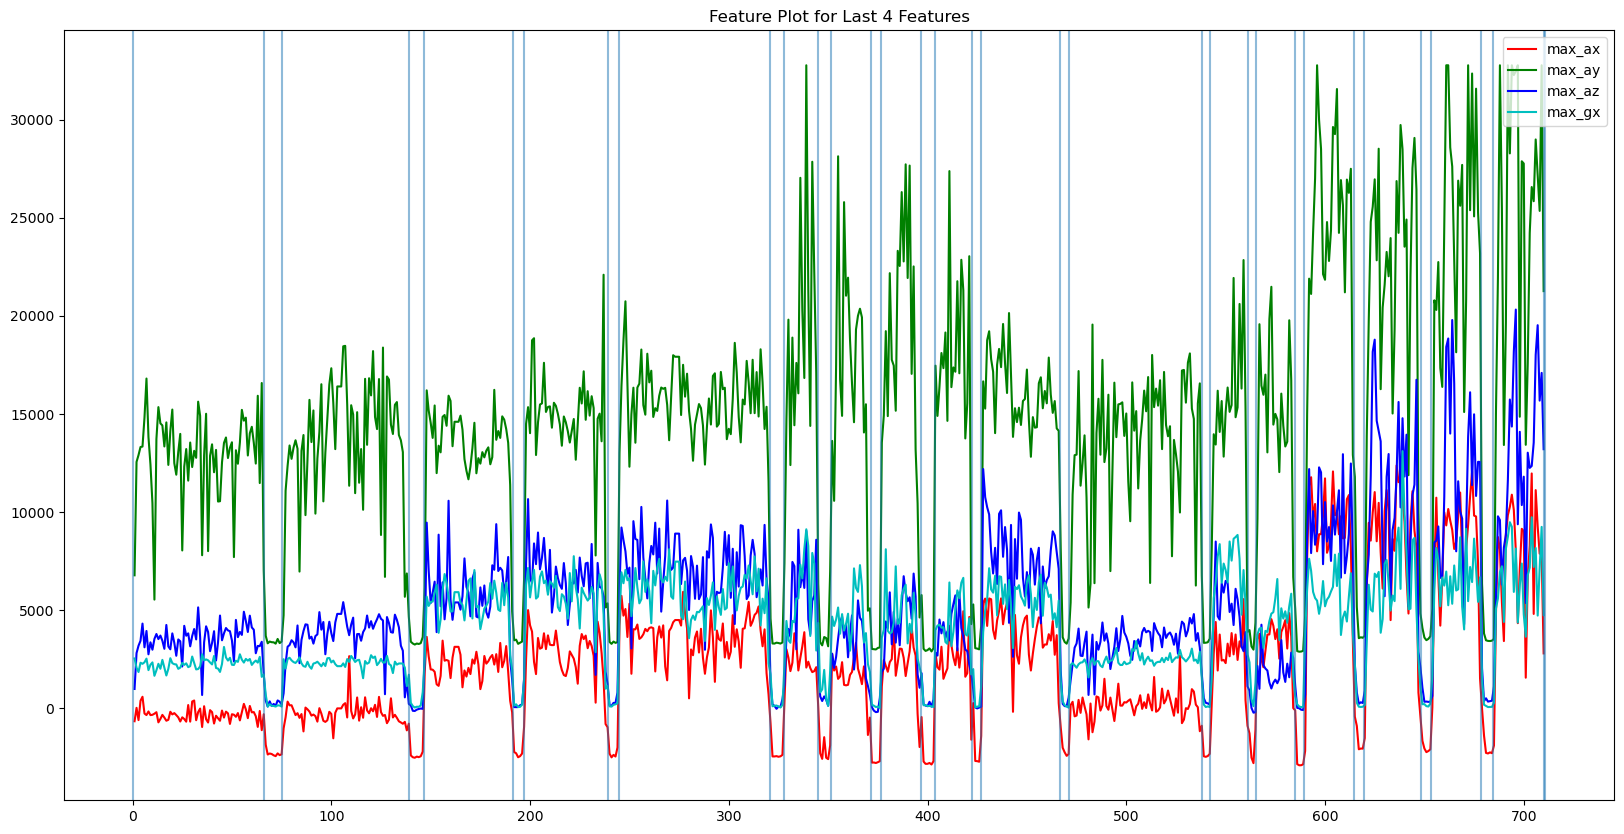

In [15]:
# Display the last 4 features of the feature set
fig, ax = plt.subplots(figsize=(20,10))

# Plot the data
ax.plot(range(1, len(feature_set) + 1),np.array(feature_set)[:,6], color='r', label='max_ax')
ax.plot(range(1, len(feature_set) + 1),np.array(feature_set)[:,7], color='g', label='max_ay')
ax.plot(range(1, len(feature_set) + 1),np.array(feature_set)[:,8], color='b', label='max_az')
ax.plot(range(1, len(feature_set) + 1),np.array(feature_set)[:,9], color='c', label='max_gx')

# Set title
ax.set_title("Feature Plot for Last 4 Features")

# Add legend
ax.legend(loc="upper right")

# Plot the location of the activity transitions just to sanity check the data
# Note: If 'activity_set' is another list of lists (or arrays) similar to the original 'feature_set', this will work.
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act), alpha=0.5)

#### Plotting all features

Plotting all the features allows us to identify any misalignments. While the display might appear dense, it's evident that the features exhibit similar patterns, and the transitions between activities are clearly visible.

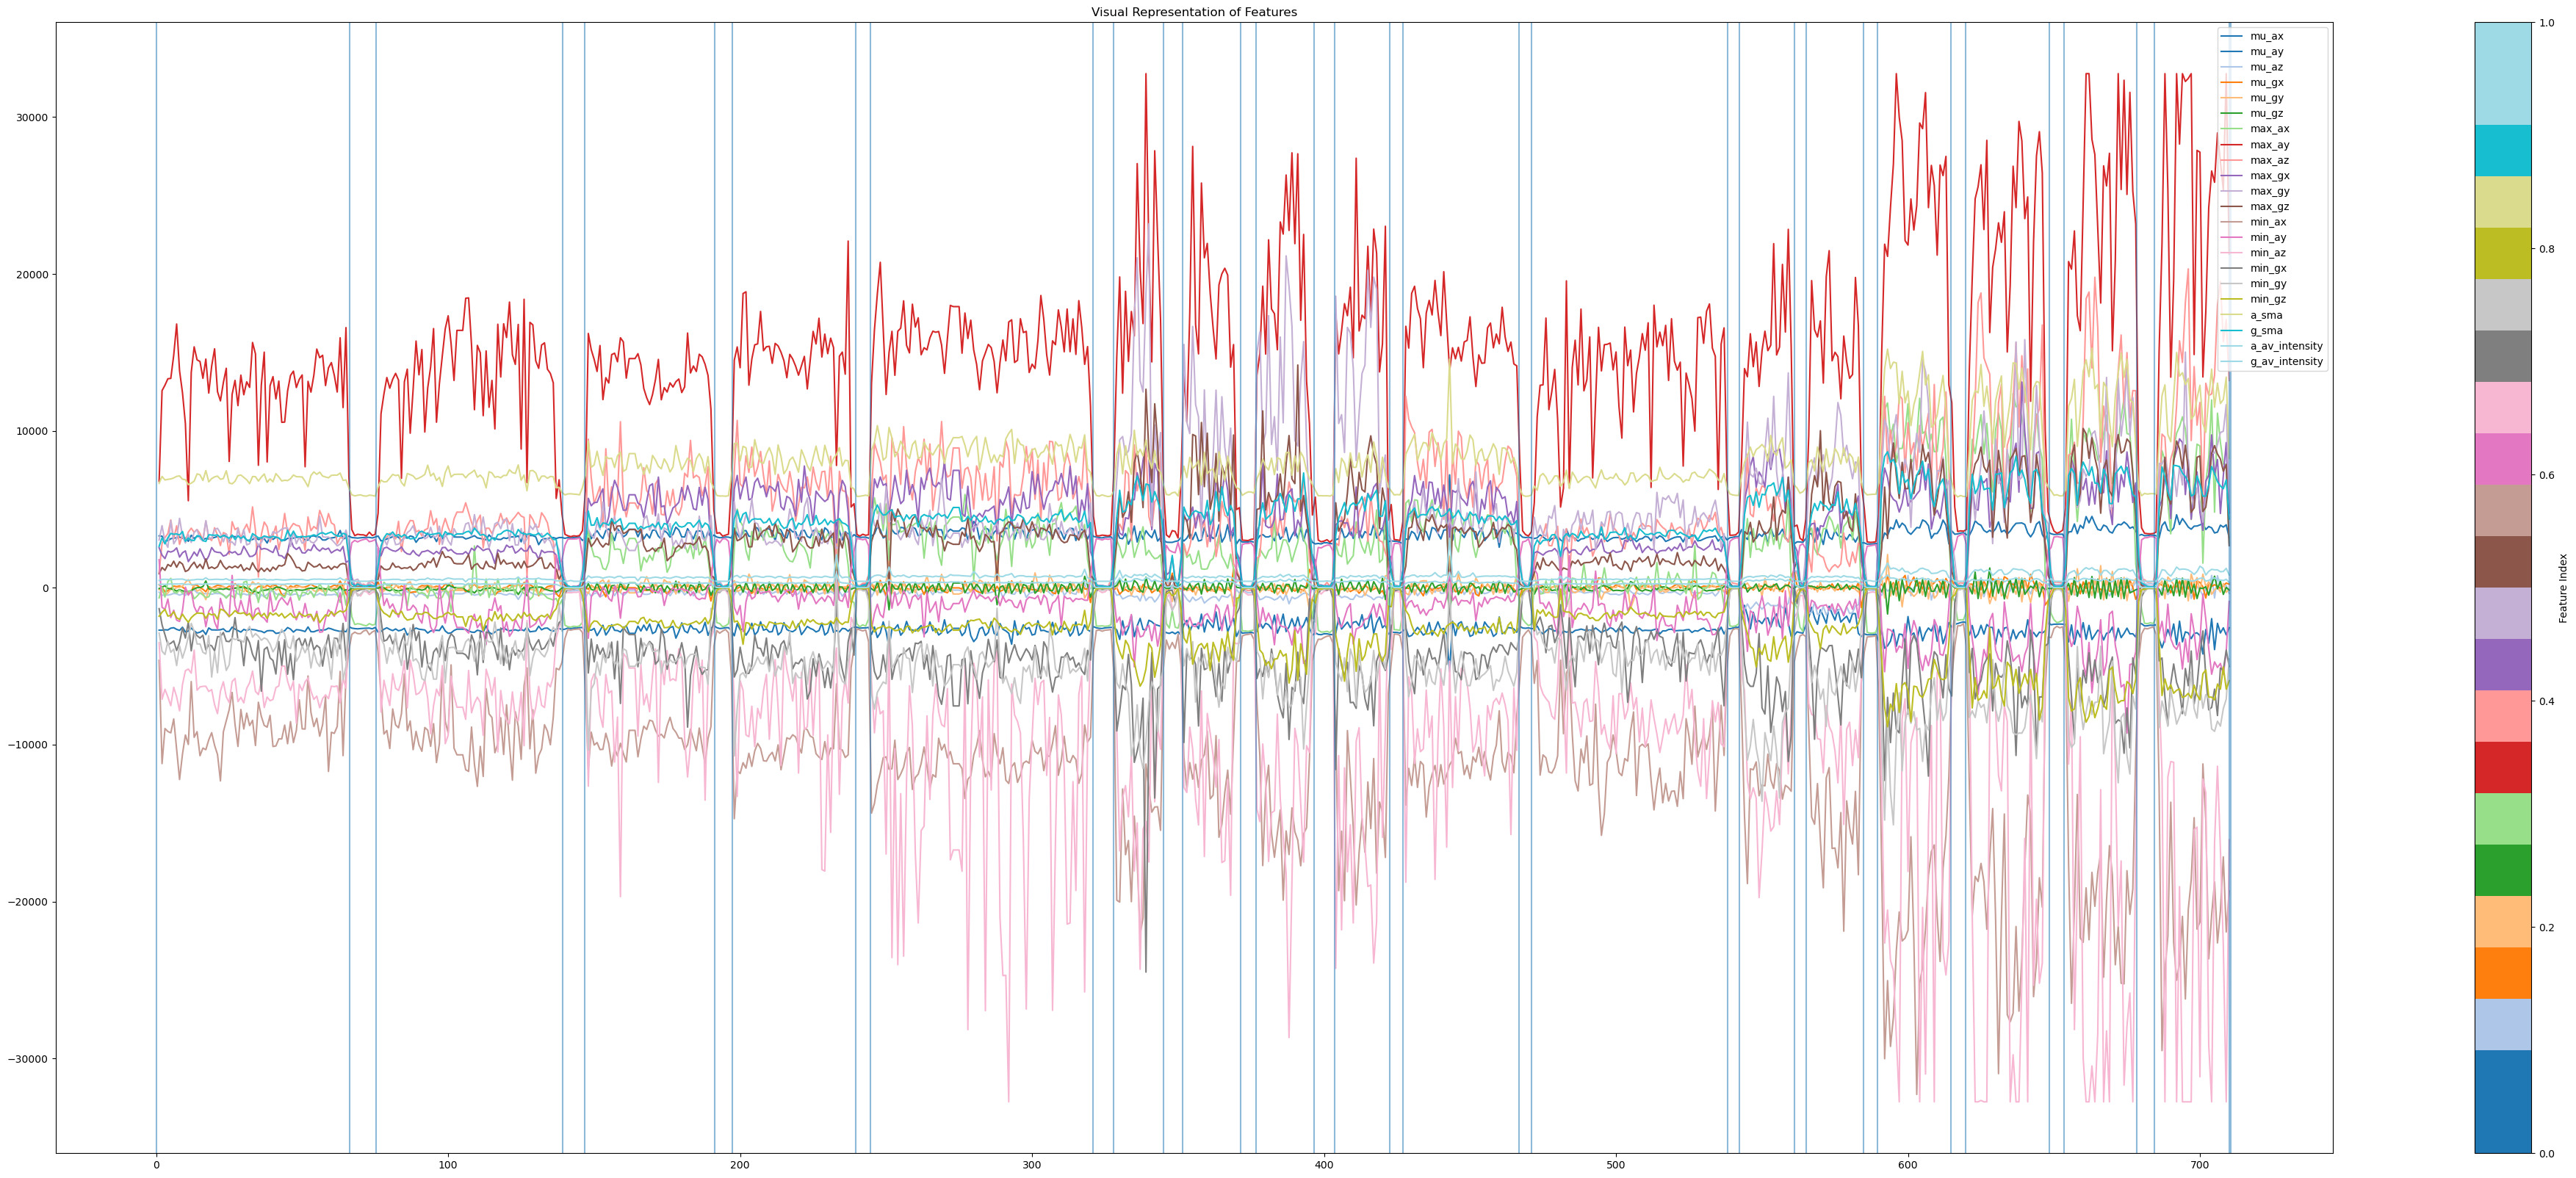

In [16]:
# Display all the features in a single plot
fig, ax = plt.subplots(figsize=(50,20))

# Titles and labels
ax.set_title("Visual Representation of Features")
feature_labels = ["mu_ax", "mu_ay", "mu_az", "mu_gx", "mu_gy", "mu_gz", 
                  "max_ax", "max_ay", "max_az", "max_gx", "max_gy", "max_gz", 
                  "min_ax", "min_ay", "min_az", "min_gx", "min_gy", "min_gz", 
                  "a_sma", "g_sma", "a_av_intensity", "g_av_intensity"]

# Get a colormap
colormap = plt.cm.get_cmap('tab20', 22)  # You can choose another colormap here

# Plot each feature with a color from the colormap
lines = []  # For storing line objects for the legend
for i in range(22):
    color = colormap(i)
    line, = ax.plot(range(1, len(feature_set) + 1), np.array(feature_set)[:, i], color=color, label=feature_labels[i])
    lines.append(line)

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0, :]:
    ax.axvline(float(act), alpha=0.5)

# Create the legend from the lines and labels
ax.legend(handles=lines, loc='upper right')

# Add a colorbar to show the mapping of colors
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap), ax=ax)
cbar.set_label('Feature Index')

#### Visualization of Accelerometer's X, Y, and Z Axes Features

A valuable perspective is provided by plotting the features of the X, Y, and Z axes. Observing the graph, it's evident that the mean features (mu_ax, mu_ay, mu_az) remain relatively consistent across various activities. Conversely, the minimum features (min_ax, min_ay, min_az) exhibit a high degree of noise.

Such insights suggest that relying on these features alone might not yield an optimal classifier model.


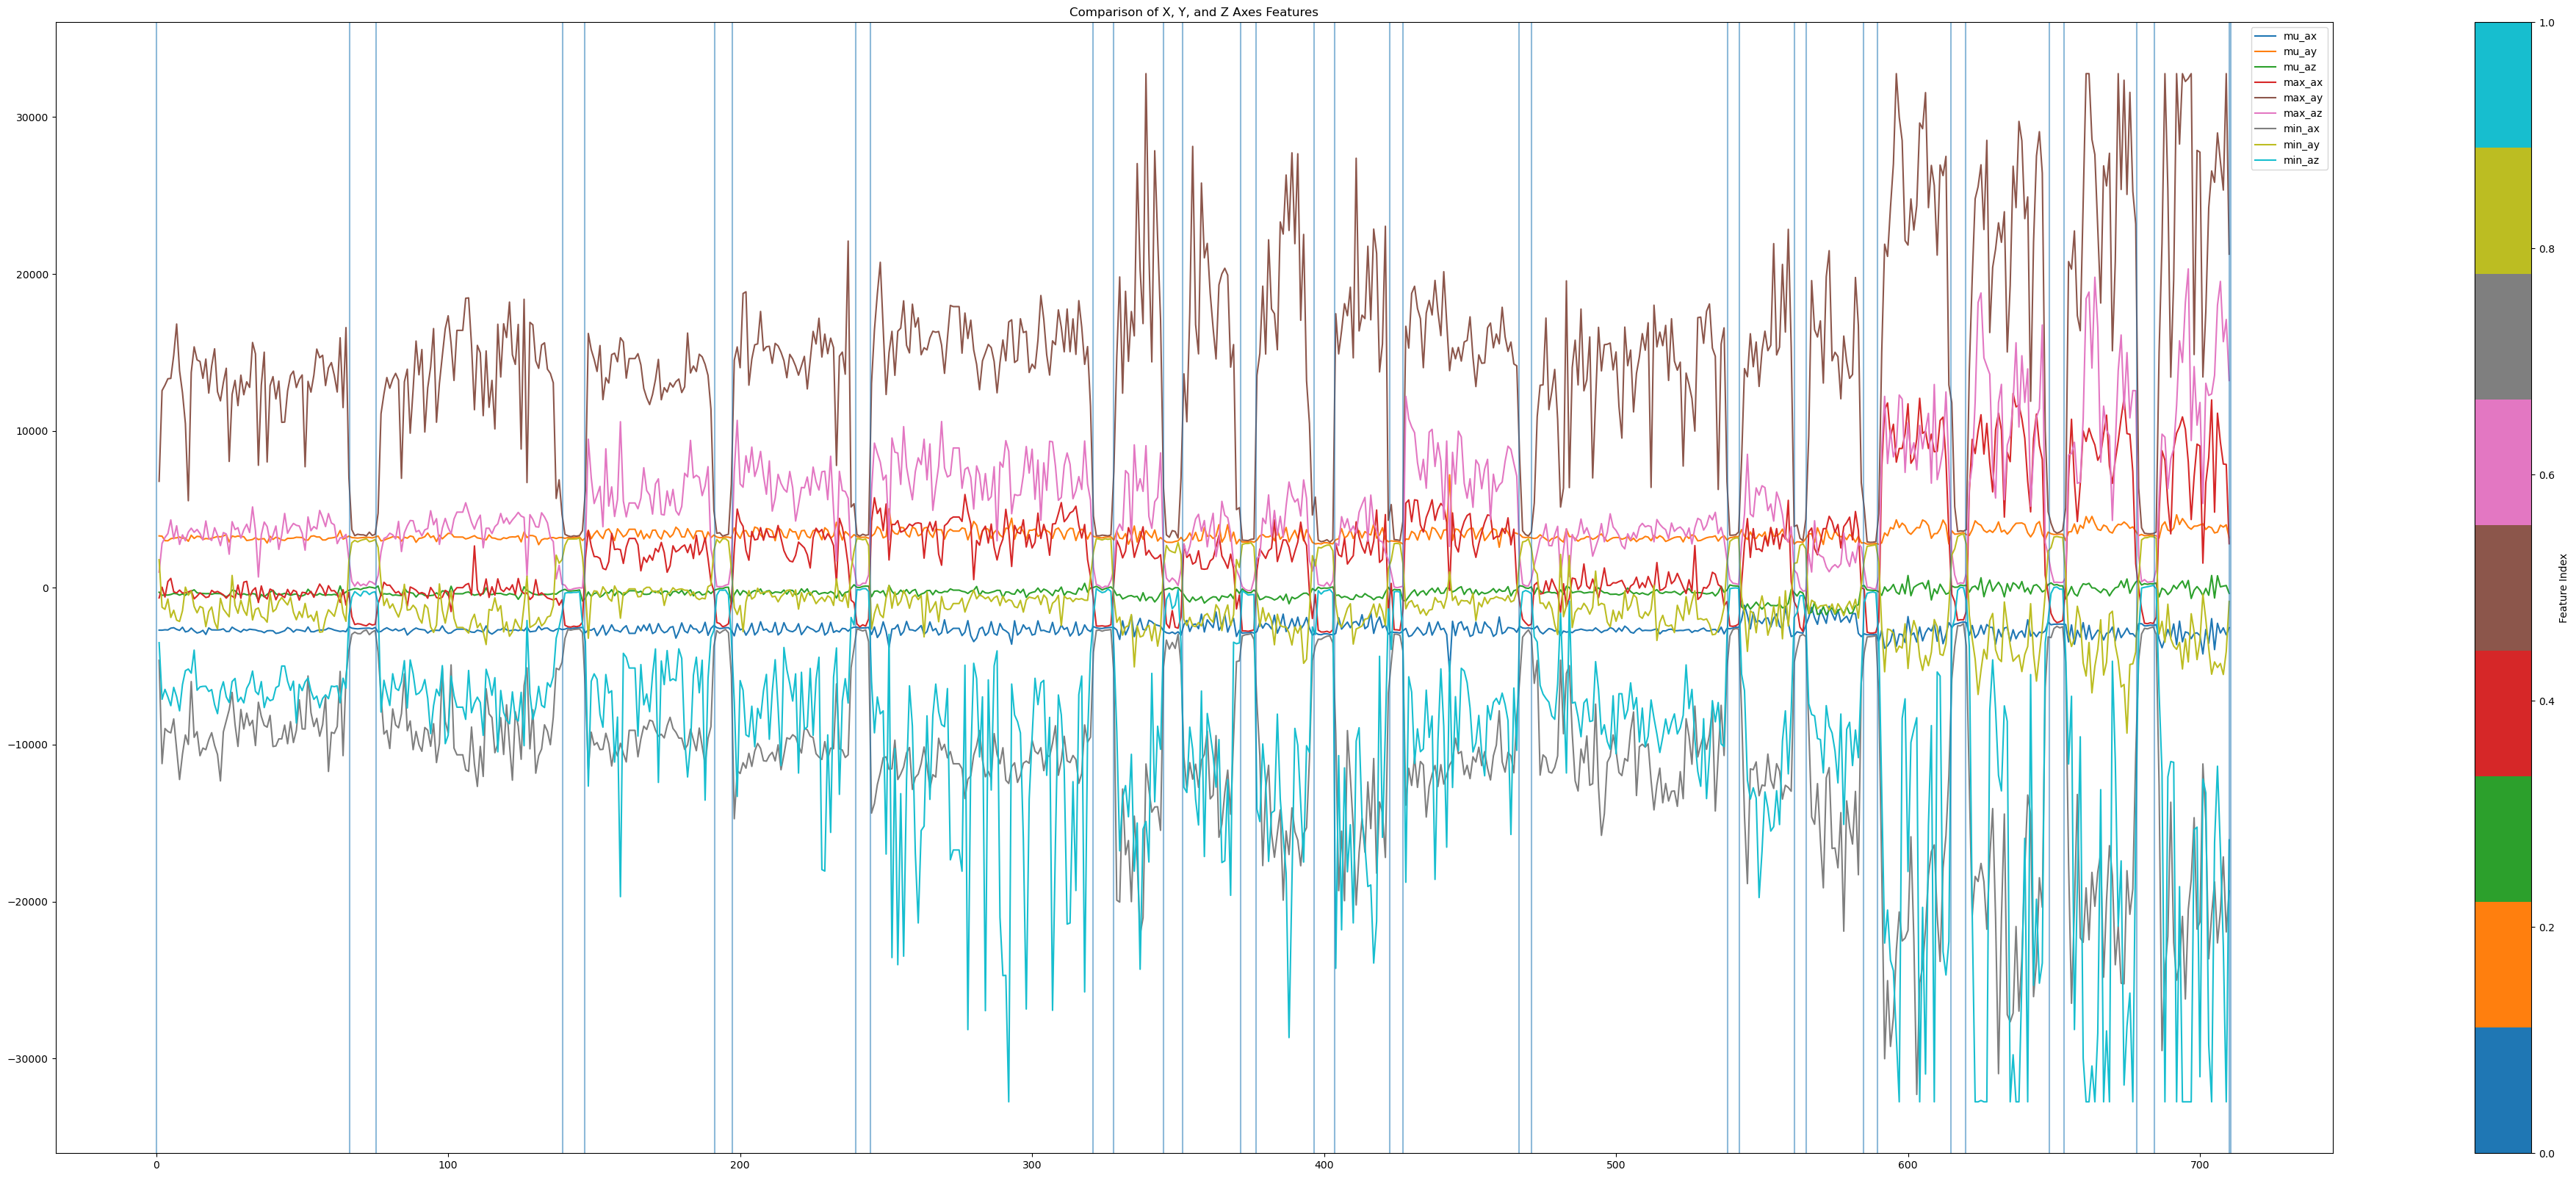

In [17]:
# Display comparison of x, y, and z axes in a single plot
fig, ax = plt.subplots(figsize=(50,20))

# Titles and labels
ax.set_title("Comparison of X, Y, and Z Axes Features")
feature_labels = ["mu_ax", "mu_ay", "mu_az", "max_ax", "max_ay", "max_az", "min_ax", "min_ay", "min_az"]

# Indices of the desired features
feature_indices = [0, 1, 2, 6, 7, 8, 12, 13, 14]

# Get a colormap
colormap = plt.cm.get_cmap('tab10', len(feature_indices))  # Adjusted the colormap size

# Plot each desired feature with a color from the colormap
lines = []  # For storing line objects for the legend
for i, feature_index in enumerate(feature_indices):
    color = colormap(i)
    line, = ax.plot(range(1, len(feature_set) + 1), np.array(feature_set)[:, feature_index], color=color, label=feature_labels[i])
    lines.append(line)

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0, :]:
    ax.axvline(float(act), alpha=0.5)

# Create the legend from the lines and labels
ax.legend(handles=lines, loc='upper right')

# Add a colorbar to show the mapping of colors
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap), ax=ax)
cbar.set_label('Feature Index')


### Scores - Helper Functions

Before initiating our model training, we've established a set of helper functions to provide a clear visualization and assessment of the model's performance.

#### Why Use These Helper Functions?

Utilizing these helper functions before diving into model training ensures you have the tools ready to thoroughly evaluate and understand the performance of your classifiers. Evaluating using multiple metrics gives a fuller picture of a model's performance, as relying on a single metric can be misleading, especially in datasets with imbalanced class distributions. Visual representations, like the confusion matrix, help in intuitively understanding the model's behavior and can guide further refinements or adjustments.

#### Descriptions of Helper Functions for Model Evaluation
1. calculate_scores:
This function computes key evaluation metrics for a classification task. These metrics are:

- Accuracy: It measures the ratio of correct predictions over the total predictions.
- Precision: This is the ratio of correctly predicted positive observations to the total predicted positives. It's crucial when the costs of false positives are high.
- Recall (Sensitivity): This indicates the ratio of correctly predicted positive observations to all the actual positives. It's essential when the cost of false negatives is high.
- F1 Score: It's the weighted average of Precision and Recall, useful for datasets with imbalanced class distributions.

2. print_scores:
This function leverages the previously defined calculate_scores function to display the computed metrics in a readable format, providing insights into how well the model performs.

3. plot_c_matrix:
This function visualizes the confusion matrix, a table used for understanding the performance of the algorithm, especially for classification problems. Each row represents the actual class, while each column signifies the predicted class. It helps to identify the kinds of errors made by the classifier.

4. show_report:
This comprehensive function provides a holistic view of the model's performance on both the training and test datasets. It prints the accuracy score, displays the confusion matrix, and presents a detailed classification report. The classification report includes precision, recall, f1-score, and support for each class, offering a deeper understanding of the model's strengths and weaknesses.

In [18]:
def calculate_scores(y_true, y_pred):
    """
    Calculate the accuracy, precision, recall, and F1 score of the predictions.
    """
    # Calculate the accuracy
    accuracy = accuracy_score(y_true, y_pred)
    # Calculate the precision
    precision = precision_score(y_true, y_pred)
    # Calculate the recall
    recall = recall_score(y_true, y_pred)
    # Calculate the F1 score
    f1 = f1_score(y_true, y_pred)
    # Return the accuracy, precision, recall, and F1 score
    return (accuracy, precision, recall, f1)

def print_scores(y_true, y_pred):
    """
    Print the accuracy, precision, recall, and F1 score of the predictions.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    """
    # Calculate the accuracy, precision, recall, and F1 score
    accuracy, precision, recall, f1 = calculate_scores(y_true, y_pred)
    # Print the accuracy, precision, recall, and F1 score
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1: {:.2f}'.format(f1))

def plot_c_matrix(clf, x, y, title):
    """
    Plot the confusion matrix for the predictions.

    Parameters
    ----------
    clf : classifier
        The classifier used to make the predictions.
    x : array-like of shape (n_samples, n_features)
        Data.
    y : array-like of shape (n_samples,)
        Target values.
    title : str
        Title of the plot.
    """
    
    # Plot the confusion matrix
    fig, ax = plt.subplots()
    disp = plot_confusion_matrix(clf, x, y,
                                    display_labels=get_activity_list(),
                                    cmap=plt.cm.Blues,ax=ax)
    # Rotate the labels so they can be read
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    ax.set_title(title)

def show_report(X_train, y_train, X_test, y_test, y_predicted, y_test_predicted, clf):
    """
    Print the accuracy, precision, recall, and F1 score of the predictions.
    
    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        Training data.
    y_train : array-like of shape (n_samples,)
        Target values.
    X_test : array-like of shape (n_samples, n_features)
        Test data.
    y_test : array-like of shape (n_samples,)
        Target values.
    y_predicted : array-like of shape (n_samples,)
        Predicted values.
    y_test_predicted : array-like of shape (n_samples,)
        Predicted values.
    clf : classifier
        The classifier used to make the predictions.
    """
    # Print the accuracy score for the training set
    print("Accuracy score for the training set: ", accuracy_score(y_train, y_predicted))

    # Print the accuracy score for the test set
    print("Accuracy score for the test set: ", accuracy_score(y_test, y_test_predicted))

    # Print the confusion matrix for the training set
    print("Confusion matrix for the training set: \n", confusion_matrix(y_train, y_predicted))

    # Print the confusion matrix for the test set
    print("Confusion matrix for the test set: \n", confusion_matrix(y_test, y_test_predicted))

    # Print the classification report for the training set
    print("Classification report for the training set: \n", classification_report(y_train, y_predicted))

    # Print the classification report for the test set
    print("Classification report for the test set: \n", classification_report(y_test, y_test_predicted))

    # Plot the confusion matrix for the training set
    disp = ConfusionMatrixDisplay.from_predictions(y_train, y_predicted, cmap=plt.cm.Blues)
    # disp.plot()
    disp.ax_.set_title("Confusion matrix for the training set")
    

    # Plot the confusion matrix for the test set
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_predicted, cmap=plt.cm.Blues)
    # disp.plot()
    disp.ax_.set_title("Confusion matrix for the test set")
    

### Training Sets and Testing Sets


In [70]:
# Get the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set)

## Random Forrest Classifier - Lucas Fonseca Martins

### Random Forest:

A Random Forest is a machine learning algorithm that belongs to the family of ensemble methods. It essentially builds multiple decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees for unseen data. The "randomness" in Random Forest comes from two main aspects:

- Random subsets of data are used to train each tree (bootstrap samples), which ensures diversity among the trees.
- A random subset of features is considered at each split within an individual tree, adding another layer of diversity and robustness.

### Why Use Random Forest for Classifying Movement Types Based on IMU Sensor Data?

1. **Handling of Complex Data**: IMU sensor data is inherently multi-dimensional, capturing acceleration and gyroscope readings in multiple axes. Random Forest can natively handle multi-dimensional features without the need for extensive feature engineering.

2. **Robustness to Overfitting**: Given that Random Forest uses multiple decision trees and each tree is trained on a random subset of data and features, it is generally more resistant to overfitting compared to a single decision tree.

3. **Versatility**: Random Forest can handle both binary and multi-class classification problems. It's well-suited for our use case where there are multiple classes of movements.

4. **Flexibility with Non-Linearity**: Movements like 'Standing', 'Walking', 'Jogging', 'Side-Step', and 'Running' may not be linearly separable based on sensor readings. Random Forest, being a non-linear classifier, can capture complex relationships in the data.

In summary, given the intricacies and potential non-linear patterns in IMU sensor data, Random Forest serves as an excellent choice for classifying different types of movements. It not only provides high accuracy but also offers insights into the underlying importance of different sensor readings, aiding in better understanding and further refinement of the classification task.

### GridSearchCV:

GridSearchCV (Grid Search Cross-Validation) is a tool used in machine learning to perform hyperparameter tuning. Essentially, it conducts an exhaustive search over a specified parameter grid, evaluating the performance of the model for each combination of hyperparameters using cross-validation, and then identifies the hyperparameters that yield the best performance.

#### Parameters:

- *estimator*: This is the machine learning model for which the hyperparameter search is being done. In your case, it's the Random Forest Classifier (rf).

- *param_grid*: It is a dictionary of hyperparameters and their respective ranges that will be considered during the search. The grid search process tests every combination of these hyperparameters to find the best model.

- *cv*: It stands for cross-validation. The number 3 indicates that 3-fold cross-validation will be used. This means the training set will be split into 3 parts: two will be used for training and one for validation. This process will rotate for each fold, ensuring every part gets a chance to be a validation set.

- *n_jobs*: Determines how many processors the algorithm can use. The value -1 means use all available processors, speeding up the search especially when the dataset is large or the grid has many combinations.

- *verbose*: Controls the verbosity of the job messages. A value of 2 means that it will display a message for each hyperparameter combination being tested.

#### `param_grid`:

The `param_grid` is a dictionary specifying the hyperparameters to be tested during the GridSearch process. For this model I used:

- *n_estimators*: Specifies the number of trees in the Random Forest. It is going to test with 10, 50, 100, and 200 trees.

- *max_depth*: Represents the maximum depth of each tree. The grid searches across no limit (None), 10, 20, and 30 levels deep.

- *min_samples_split*: Dictates the minimum number of samples required to split an internal node. The search will consider splits at 2, 5, and 10 samples.

- *min_samples_leaf*: Defines the minimum number of samples required to be at a leaf node. The values to be considered are 1, 2, and 4 samples.

- *bootstrap*: A boolean value to decide whether or not to use bootstrap samples when building trees. The grid will test for both using bootstrap (True) and not using bootstrap (False).



In [20]:
# Random Forest Classifier

# Set up the environment
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define the model
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the accuracy
y_pred = grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.949438202247191


### Feature Importance

In the context of Random Forests, the `feature importance` indicates the significance of each feature in predicting the target variable. In simple terms, it answers the question: "Which features are most influential in making a prediction?"

Here we display the importance of each feature ordered by the most influence on the model's decisions.

In [21]:
# Use the best estimator from your grid search
importances = grid_search.best_estimator_.feature_importances_

feature_labels = ["mu_ax", "mu_ay", "mu_az", "mu_gx", "mu_gy", "mu_gz", 
                  "max_ax", "max_ay", "max_az", "max_gx", "max_gy", "max_gz", 
                  "min_ax", "min_ay", "min_az", "min_gx", "min_gy", "min_gz", 
                  "a_sma", "g_sma", "a_av_intensity", "g_av_intensity"]

# Convert feature importances to a DataFrame
df_importances = pd.DataFrame({
    'Feature': feature_labels,
    'Importance': importances
})

# Sort the DataFrame by importances
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Set display settings
pd.set_option('display.max_rows', 25)
pd.set_option('display.float_format', '{:.4f}'.format)

# Display the sorted DataFrame with improved formatting
df_importances.style.bar(subset=['Importance'], color='#d65f5f') \
    .highlight_max(subset='Importance', color='lightgreen')


### Visualizing the Features
Because we are using a random forest classifier, we cannot visualize individual trees; it would be too crowded. So, I decided to use partial dependence plots: one for the best feature and one for the worst.

#### Partial Dependence Plots (PDPs)
A Partial Dependence Plot is a tool that visualizes the marginal effect of a feature on the target variable. This means it shows how a specific feature influences the predicted outcome across various values, while keeping all other features constant.

#### Worst Feature
As we can see in the plot for the worst feature, the lines are flat, indicating that the feature has no effect. 

#### Best Feature
The plot for the best feature has parabolic peaks. The peak might indicate a particular intensity of gravity that corresponds to the most frequent or significant occurrence of that activity.


C:\Users\klwon\anaconda3\envs\py37\lib\site-packages\sklearn\inspection\_partial_dependence.py:513: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  FutureWarning,
C:\Users\klwon\anaconda3\envs\py37\lib\site-packages\sklearn\inspection\_partial_dependence.py:513: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  FutureWarning,


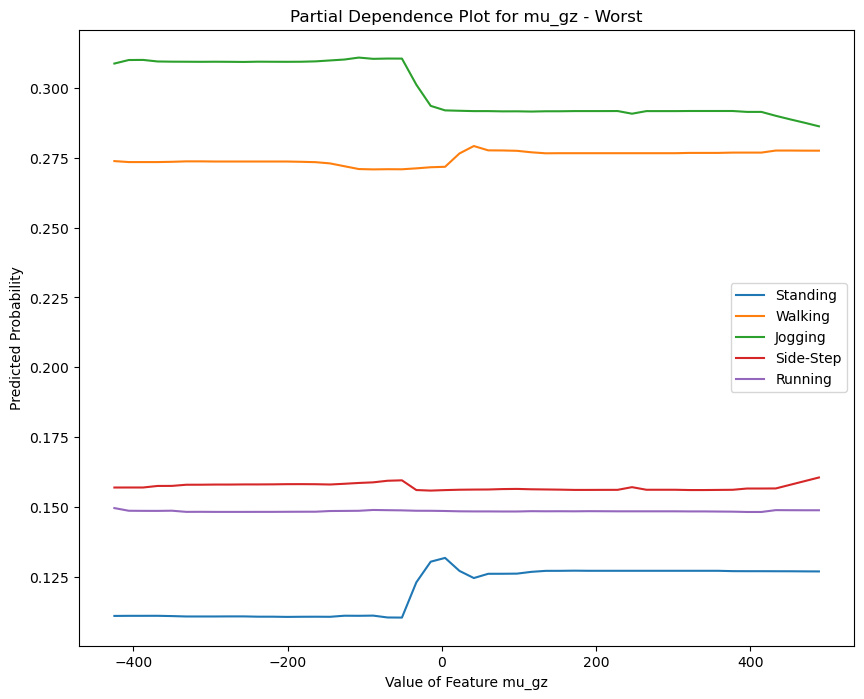

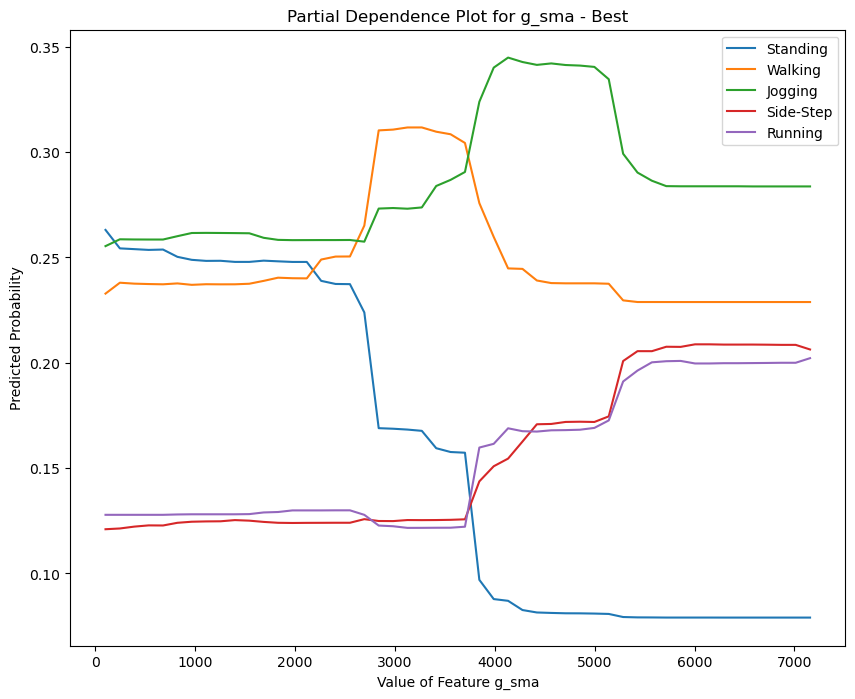

In [22]:
# Invert the dictionary for reverse lookup
activity_mapping_inv = {v: k for k, v in activity_mapping.items()}

def plot_partial_dependence(feature_index, title):
    # Your selected feature for which you want to plot PDP
    features = [df_importances.iloc[feature_index].name]

    # Set up a figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Get unique classes
    classes = grid_search.best_estimator_.classes_

    # Get PDP values
    pdp_values, axes = partial_dependence(grid_search.best_estimator_, 
                                          X_train, 
                                          features=features, 
                                          grid_resolution=50, 
                                          percentiles=(0.05, 0.95),
                                          method='auto')

    # Plot each class' PDP using a loop
    for target_class, pdp_for_class in zip(classes, pdp_values):
        # Use the inverted activity mapping to get string labels
        label = activity_mapping_inv.get(target_class, f"Class {target_class}")
        ax.plot(axes[0], pdp_for_class.ravel(), label=label)

    # Add legend to differentiate lines for different classes
    ax.legend()

    # Set the title for the plot
    title = f"Partial Dependence Plot for {df_importances.iloc[feature_index]['Feature']} - {title}"
    ax.set_title(title)

    # Add x and y labels
    ax.set_xlabel(f"Value of Feature {df_importances.iloc[feature_index]['Feature']}")
    ax.set_ylabel("Predicted Probability")

# Plot the partial dependence for the most important feature and least important feature
plot_partial_dependence(-1, "Worst")
plot_partial_dependence(0, "Best")

### Show reports

Now this code segment evaluates the performance of a trained model on both training and testing datasets.

Accuracy score for the training set:  1.0
Accuracy score for the test set:  0.949438202247191
Confusion matrix for the training set: 
 [[ 69   0   0   0   0]
 [  0 145   0   0   0]
 [  0   0 156   0   0]
 [  0   0   0  83   0]
 [  0   0   0   0  79]]
Confusion matrix for the test set: 
 [[17  0  0  5  0]
 [ 0 53  0  0  0]
 [ 0  1 46  0  0]
 [ 1  1  0 29  0]
 [ 1  0  0  0 24]]
Classification report for the training set: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00       145
           2       1.00      1.00      1.00       156
           3       1.00      1.00      1.00        83
           4       1.00      1.00      1.00        79

    accuracy                           1.00       532
   macro avg       1.00      1.00      1.00       532
weighted avg       1.00      1.00      1.00       532

Classification report for the test set: 
               precision    recall  f1-score 

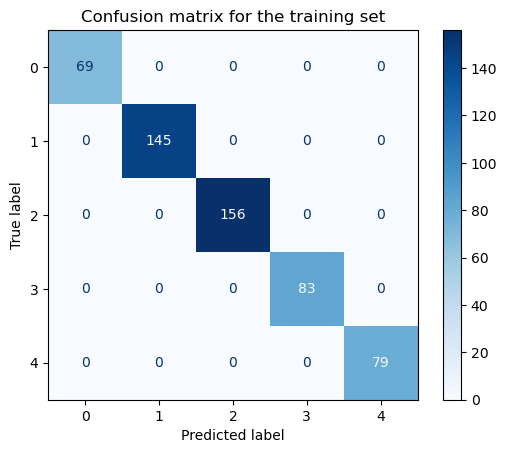

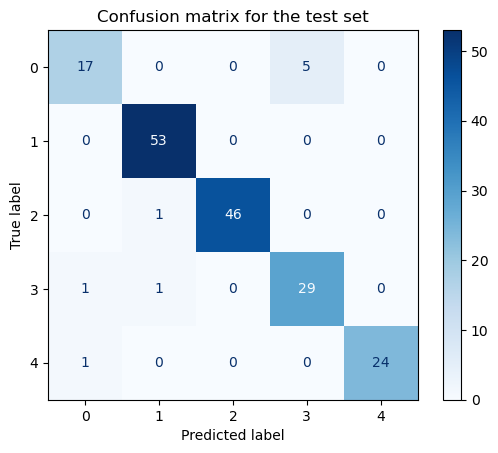

In [23]:
y_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)

show_report(X_train, y_train, X_test, y_test, y_pred, y_test_pred, grid_search)

## AdaBoost Classifier - Kim Wong

AdaBoost stands for Adaptive Boosting. It employs the concept of weak learners, which are defined as slightly better than random guessing, to create a strong learner. This is done in a sequential manner where the weights of misclassified data are amplified so each subsequent iteration of the training process can learn more from the “mistakes” of previous iterations. 

For example:

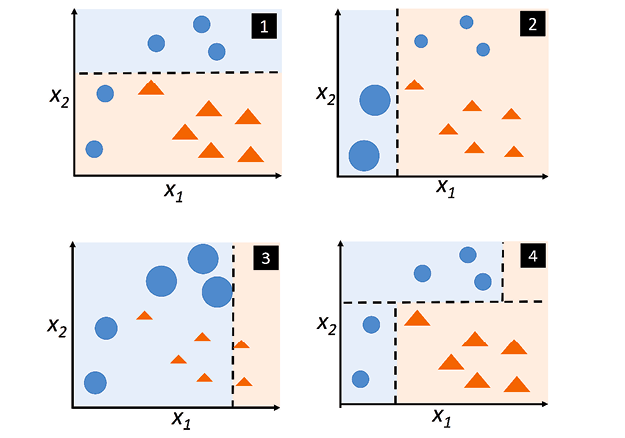

There are pros and cons to using AdaBoost in the task of activity classification in this assignment. Firstly, and importantly, AdaBoost can be used in multiclass classification when the `algorithm` parameter is SAMME.R, which is its default setting. It can also be used effectively with other models to help improve their accuracy. It’s also generally less prone to overfitting when the learners are sufficiently weak and due to the constant adjustment of weights.  

Without proper pre-processing of data to account for errors and outliers, however, AdaBoost can diminish in accuracy. In the context of this assignment the IMU sensor data has been largely processed for potential errors and from a visual inspection of the features plot above, there doesn’t seem to be many outlier occurrences. Another issue, however, that AdaBoost can struggle with is class imbalance, which may account for some inaccuracies ahead as there is clearly higher sizes of some classes (such as Jogging and Walking) than others. 

In terms of parameters, in addition to the `algorithm` parameter that must remain as the default SAMME.R, there are a few other ones that have been investigated. As stated earlier, AdaBoost is an algorithm that works in conjunction with other models, and the `base_estimator` parameter is where those models are specified. The default base estimator is the DecisionTreeClassifier() with a maximum depth of 1, a weak learner otherwise known as a decision stump. The hyperparameters that require optimizing are `learning_rate`, defined as the weight applied to each classifier at each boosting iteration, and `n_estimators`, which is the maximum number of estimators to perform boosting.

For the tuning of hyperparameters, two methods have been used: RandomizedSearchCV and GridSearchCV. RandomizedSearchCV is similar to GridSearchCV in that it utilises a brute force method to find optimal hyperparameters. However, instead of specifying a list of discrete values for each hyperparameter, a range of values are specified which the method can then randomly sample from for the specified amount of iterations.

In this section there are a few instances of AdaBoost. One is the untuned base model with default parameters, another is the base model tuned using RandomizedSearchCV, the third is the base model tuned using GridSearchCV and the final one again uses RandomizedSearchCV for hyperparameter tuning, however the base estimator is a more complex DecisionTreeClassifier() which utilises additional hyperparameters.

In [71]:
# Import libraries (to be moved to top)
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
from IPython.display import display

# Copy of feature labels used in feature importance plots
feature_labels_copy = ["mu_ax", "mu_ay", "mu_az", "mu_gx", "mu_gy", "mu_gz", 
                  "max_ax", "max_ay", "max_az", "max_gx", "max_gy", "max_gz", 
                  "min_ax", "min_ay", "min_az", "min_gx", "min_gy", "min_gz", 
                  "a_sma", "g_sma", "a_av_intensity", "g_av_intensity"]

# Create dataframe for accuracy score summary
df_scores = pd.DataFrame(columns =["Classifier", "Accuracy score for training set", "Accuracy score for testing set"])


### AdaBoost Classifier with decision stump as the base estimator

#### Untuned AdaBoost Classifier

In [72]:
# Define the model
ds_ut = AdaBoostClassifier()

# Show parameters for the basic AdaBoost classifier
ds_ut.get_params()


{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [73]:
# Fit the model to the training data
ds_ut.fit(X_train, y_train)


AdaBoostClassifier()

Accuracy score for the training set:  0.8045112781954887
Accuracy score for the test set:  0.7528089887640449
Confusion matrix for the training set: 
 [[  8   2   6  49   0]
 [  0 139   0   2   0]
 [  6   0 149   1   1]
 [  1   3   1  79   4]
 [  0   0   2  26  53]]
Confusion matrix for the test set: 
 [[ 1  1  1 23  0]
 [ 0 53  3  1  0]
 [ 2  0 43  1  0]
 [ 1  1  0 23  1]
 [ 0  0  0  9 14]]
Classification report for the training set: 
               precision    recall  f1-score   support

           0       0.53      0.12      0.20        65
           1       0.97      0.99      0.98       141
           2       0.94      0.95      0.95       157
           3       0.50      0.90      0.64        88
           4       0.91      0.65      0.76        81

    accuracy                           0.80       532
   macro avg       0.77      0.72      0.71       532
weighted avg       0.82      0.80      0.78       532

Classification report for the test set: 
               precision    r

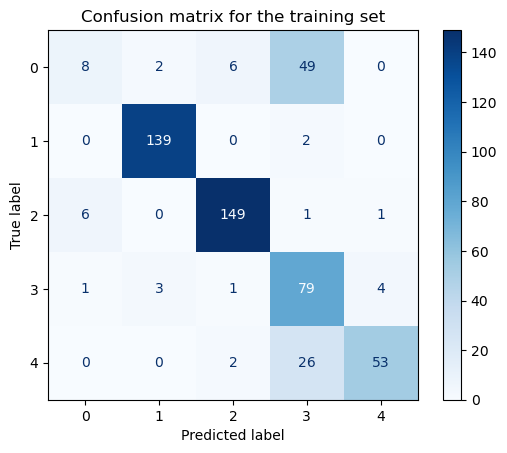

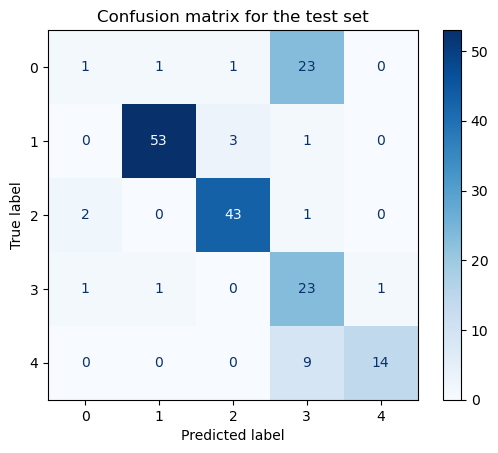

In [74]:
# Make predictions using the trained model
ds_ut_test_pred = ds_ut.predict(X_test)
ds_ut_train_pred = ds_ut.predict(X_train)

# Show metrics for the trained model
show_report(X_train, y_train, X_test, y_test, ds_ut_train_pred, ds_ut_test_pred, ds_ut)

# Modify scores summary table
drop_1 = df_scores["Classifier"] == "AdaBoost, Decision Stump, Untuned"
df_scores = df_scores[~drop_1]
df_scores = df_scores.append({"Classifier": "AdaBoost, Decision Stump, Untuned",
                              "Accuracy score for training set": accuracy_score(y_train,ds_ut_train_pred), 
                              "Accuracy score for testing set": accuracy_score(y_test,ds_ut_test_pred)}, 
                             ignore_index=True)


#### Tuned AdaBoost Classifier using RandomizedSearchCV

In [75]:
# Define the model
ds_t1 = AdaBoostClassifier(random_state=71)

# Set parameters for RandomizedSearchCV
param_ds_rand = {"n_estimators": randint(50, 1000), "learning_rate": uniform()}

# Create a RandomizedSearchCV object
ds_rand = RandomizedSearchCV(estimator = ds_t1, param_distributions = param_ds_rand, n_iter=20, cv=3, n_jobs=-1, verbose=1)


In [76]:
# Fit the object to the training data
ds_rand.fit(X_train, y_train)

# Output the best parameters identified
print("Best Parameters from using RandomizedSearchCV:")
for key, value in ds_rand.best_params_.items():
    print(key,":",value)
    

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters from using RandomizedSearchCV:
learning_rate : 0.919764631976765
n_estimators : 956


Accuracy score for the training set:  0.9398496240601504
Accuracy score for the test set:  0.8539325842696629
Confusion matrix for the training set: 
 [[ 59   1   2   3   0]
 [  2 139   0   0   0]
 [  1   0 155   0   1]
 [  3   2   0  75   8]
 [  0   0   0   9  72]]
Confusion matrix for the test set: 
 [[17  2  0  6  1]
 [ 1 54  2  0  0]
 [ 1  1 44  0  0]
 [ 2  2  0 22  0]
 [ 0  0  2  6 15]]
Classification report for the training set: 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        65
           1       0.98      0.99      0.98       141
           2       0.99      0.99      0.99       157
           3       0.86      0.85      0.86        88
           4       0.89      0.89      0.89        81

    accuracy                           0.94       532
   macro avg       0.92      0.92      0.92       532
weighted avg       0.94      0.94      0.94       532

Classification report for the test set: 
               precision    r

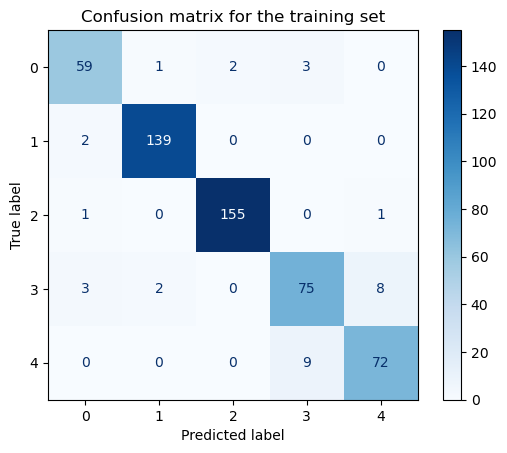

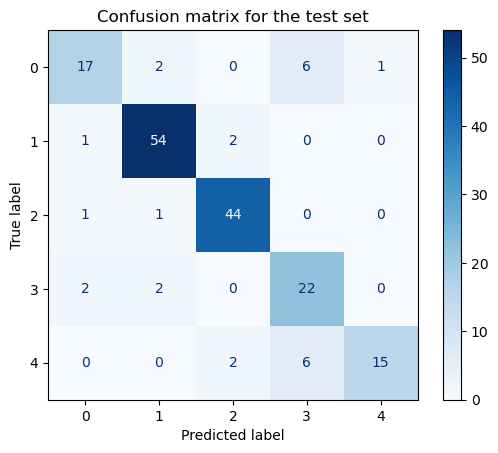

In [77]:
# Make predictions using the trained model
best_ds_rand = ds_rand.best_estimator_
ds_rand_test_pred = best_ds_rand.predict(X_test)
ds_rand_train_pred = best_ds_rand.predict(X_train)

# Show metrics for the trained model
show_report(X_train, y_train, X_test, y_test, ds_rand_train_pred, ds_rand_test_pred, ds_rand)

# Modify scores summary table
drop_2 = df_scores["Classifier"] == "AdaBoost, Decision Stump, RandomizedSearchCV"
df_scores = df_scores[~drop_2]
df_scores = df_scores.append({"Classifier": "AdaBoost, Decision Stump, RandomizedSearchCV",
                              "Accuracy score for training set": accuracy_score(y_train,ds_rand_train_pred), 
                              "Accuracy score for testing set": accuracy_score(y_test,ds_rand_test_pred)}, 
                             ignore_index=True)


#### Tuned AdaBoost Classifier using GridSearchCV

In [78]:
# Define the model
ds_t2 = AdaBoostClassifier()

# Set parameters for GridSearchCV
param_ds_grid = {"n_estimators": [50, 100, 250, 500, 750, 1000], "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1]}

# Create a GridSearchCV object
ds_grid = GridSearchCV(estimator = ds_t2, param_grid = param_ds_grid, cv=3, n_jobs=-1, verbose=1)


In [79]:
# Fit the object to the training data
ds_grid.fit(X_train, y_train)

# Output the best parameters identified
print("Best Parameters from using GridSearchCV:")
for key, value in ds_grid.best_params_.items():
    print(key,":",value)
    

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters from using GridSearchCV:
learning_rate : 1
n_estimators : 100


Accuracy score for the training set:  0.8007518796992481
Accuracy score for the test set:  0.7640449438202247
Confusion matrix for the training set: 
 [[ 15   1   3  45   1]
 [  2 137   0   2   0]
 [  4   0 150   1   2]
 [  1   3   1  70  13]
 [  0   0   1  26  54]]
Confusion matrix for the test set: 
 [[ 3  1  0 20  2]
 [ 2 52  2  1  0]
 [ 0  0 45  1  0]
 [ 0  1  2 21  2]
 [ 1  0  1  6 15]]
Classification report for the training set: 
               precision    recall  f1-score   support

           0       0.68      0.23      0.34        65
           1       0.97      0.97      0.97       141
           2       0.97      0.96      0.96       157
           3       0.49      0.80      0.60        88
           4       0.77      0.67      0.72        81

    accuracy                           0.80       532
   macro avg       0.78      0.72      0.72       532
weighted avg       0.82      0.80      0.79       532

Classification report for the test set: 
               precision    r

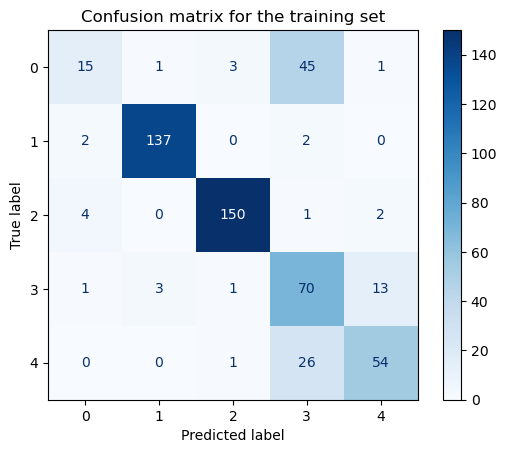

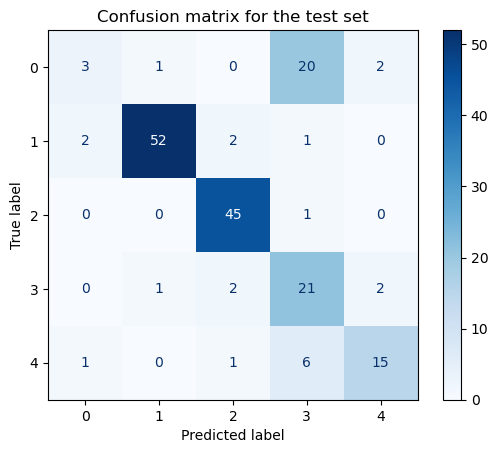

In [80]:
# Make predictions using the trained model
best_ds_grid = ds_grid.best_estimator_
ds_grid_test_pred = best_ds_grid.predict(X_test)
ds_grid_train_pred = best_ds_grid.predict(X_train)

# Show metrics for the trained model
show_report(X_train, y_train, X_test, y_test, ds_grid_train_pred, ds_grid_test_pred, ds_grid)

# Modify scores summary table
drop_3 = df_scores["Classifier"] == "AdaBoost, Decision Stump, GridSearchCV"
df_scores = df_scores[~drop_3]
df_scores = df_scores.append({"Classifier": "AdaBoost, Decision Stump, GridSearchCV",
                              "Accuracy score for training set": accuracy_score(y_train,ds_grid_train_pred),
                              "Accuracy score for testing set": accuracy_score(y_test,ds_grid_test_pred)},
                             ignore_index=True)


### AdaBoost Classifier with decision tree as the base estimator

#### Tuned AdaBoost Classifier using RandomizedSearchCV

In [81]:
# Define the model
ada_dt = AdaBoostClassifier(DecisionTreeClassifier())

# Show parameters for the AdaBoost classifier with a decision tree base estimator
ada_dt.get_params()

# Set parameters for RandomizedSearchCV
param_dt_rand = {"base_estimator__max_depth": randint(1,10), "base_estimator__min_samples_split": randint(2,10), 
                 "base_estimator__min_samples_leaf": randint(2,5), 
                 "n_estimators": randint(50,1000), "learning_rate": uniform()} 

# Create a RandomizedSearchCV object
dt_rand = RandomizedSearchCV(estimator = ada_dt, param_distributions = param_dt_rand, n_iter=20, cv=3, n_jobs=-1, verbose=1)


In [82]:
# Fit the object to the training data
dt_rand.fit(X_train, y_train)

# Output the best parameters identified
print("Best Parameters from RandomizedSearchCV for AdaBoost Classifer with Decision Tree as Base Estimator:")
for key, value in dt_rand.best_params_.items():
    print(key,":",value)
    

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters from RandomizedSearchCV for AdaBoost Classifer with Decision Tree as Base Estimator:
base_estimator__max_depth : 8
base_estimator__min_samples_leaf : 4
base_estimator__min_samples_split : 2
learning_rate : 0.9926327164329831
n_estimators : 775


Accuracy score for the training set:  1.0
Accuracy score for the test set:  0.9269662921348315
Confusion matrix for the training set: 
 [[ 65   0   0   0   0]
 [  0 141   0   0   0]
 [  0   0 157   0   0]
 [  0   0   0  88   0]
 [  0   0   0   0  81]]
Confusion matrix for the test set: 
 [[21  2  0  3  0]
 [ 2 53  2  0  0]
 [ 2  0 44  0  0]
 [ 0  1  0 25  0]
 [ 1  0  0  0 22]]
Classification report for the training set: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00       141
           2       1.00      1.00      1.00       157
           3       1.00      1.00      1.00        88
           4       1.00      1.00      1.00        81

    accuracy                           1.00       532
   macro avg       1.00      1.00      1.00       532
weighted avg       1.00      1.00      1.00       532

Classification report for the test set: 
               precision    recall  f1-score

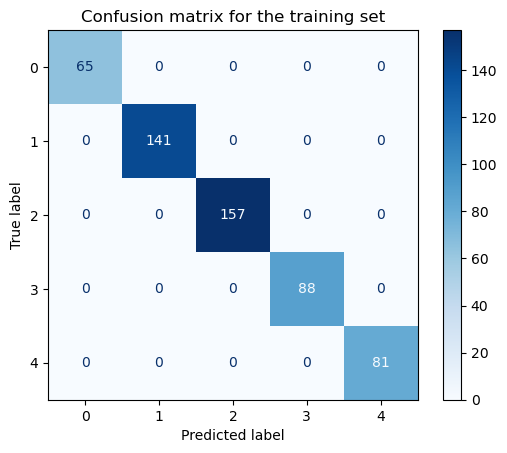

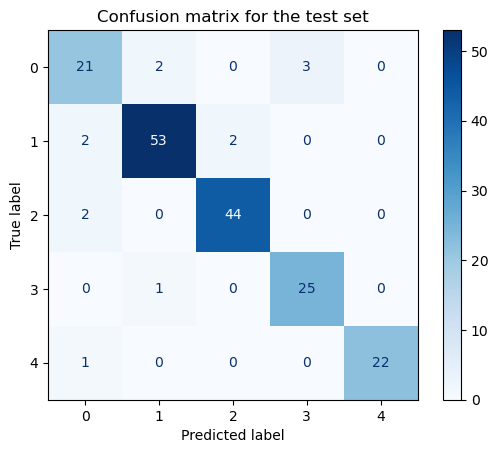

In [83]:
# Make predictions using the trained model
best_dt_rand = dt_rand.best_estimator_
dt_rand_test_pred = best_dt_rand.predict(X_test)
dt_rand_train_pred = best_dt_rand.predict(X_train)

# Show metrics for the trained model
show_report(X_train, y_train, X_test, y_test, dt_rand_train_pred, dt_rand_test_pred, dt_rand)

# Modify scores summary table
drop_4 = df_scores["Classifier"] == "AdaBoost, Decision Tree, RandomizedSearchCV"
df_scores = df_scores[~drop_4]
df_scores = df_scores.append({"Classifier": "AdaBoost, Decision Tree, RandomizedSearchCV",
                              "Accuracy score for training set": accuracy_score(y_train,dt_rand_train_pred), 
                              "Accuracy score for testing set": accuracy_score(y_test,dt_rand_test_pred)}, 
                             ignore_index=True)


#### Summary of accuracy scores
The following table shows the values of accuracy scores across all the AdaBoost models that have been created.


In [84]:
df_scores

Classifier  \
0             AdaBoost, Decision Stump, Untuned   
1  AdaBoost, Decision Stump, RandomizedSearchCV   
2        AdaBoost, Decision Stump, GridSearchCV   
3   AdaBoost, Decision Tree, RandomizedSearchCV   

   Accuracy score for training set  Accuracy score for testing set  
0                           0.8045                          0.7528  
1                           0.9398                          0.8539  
2                           0.8008                          0.7640  
3                           1.0000                          0.9270

### Visual - Feature Importances
The following shows a graphical representation of the feature importances, derived from the best estimator for each instance of the AdaBoost algorithm.

[Text(0.5, 1.0, 'Tuned using RandomizedSearchCV, Base Estimator: Decision Tree')]

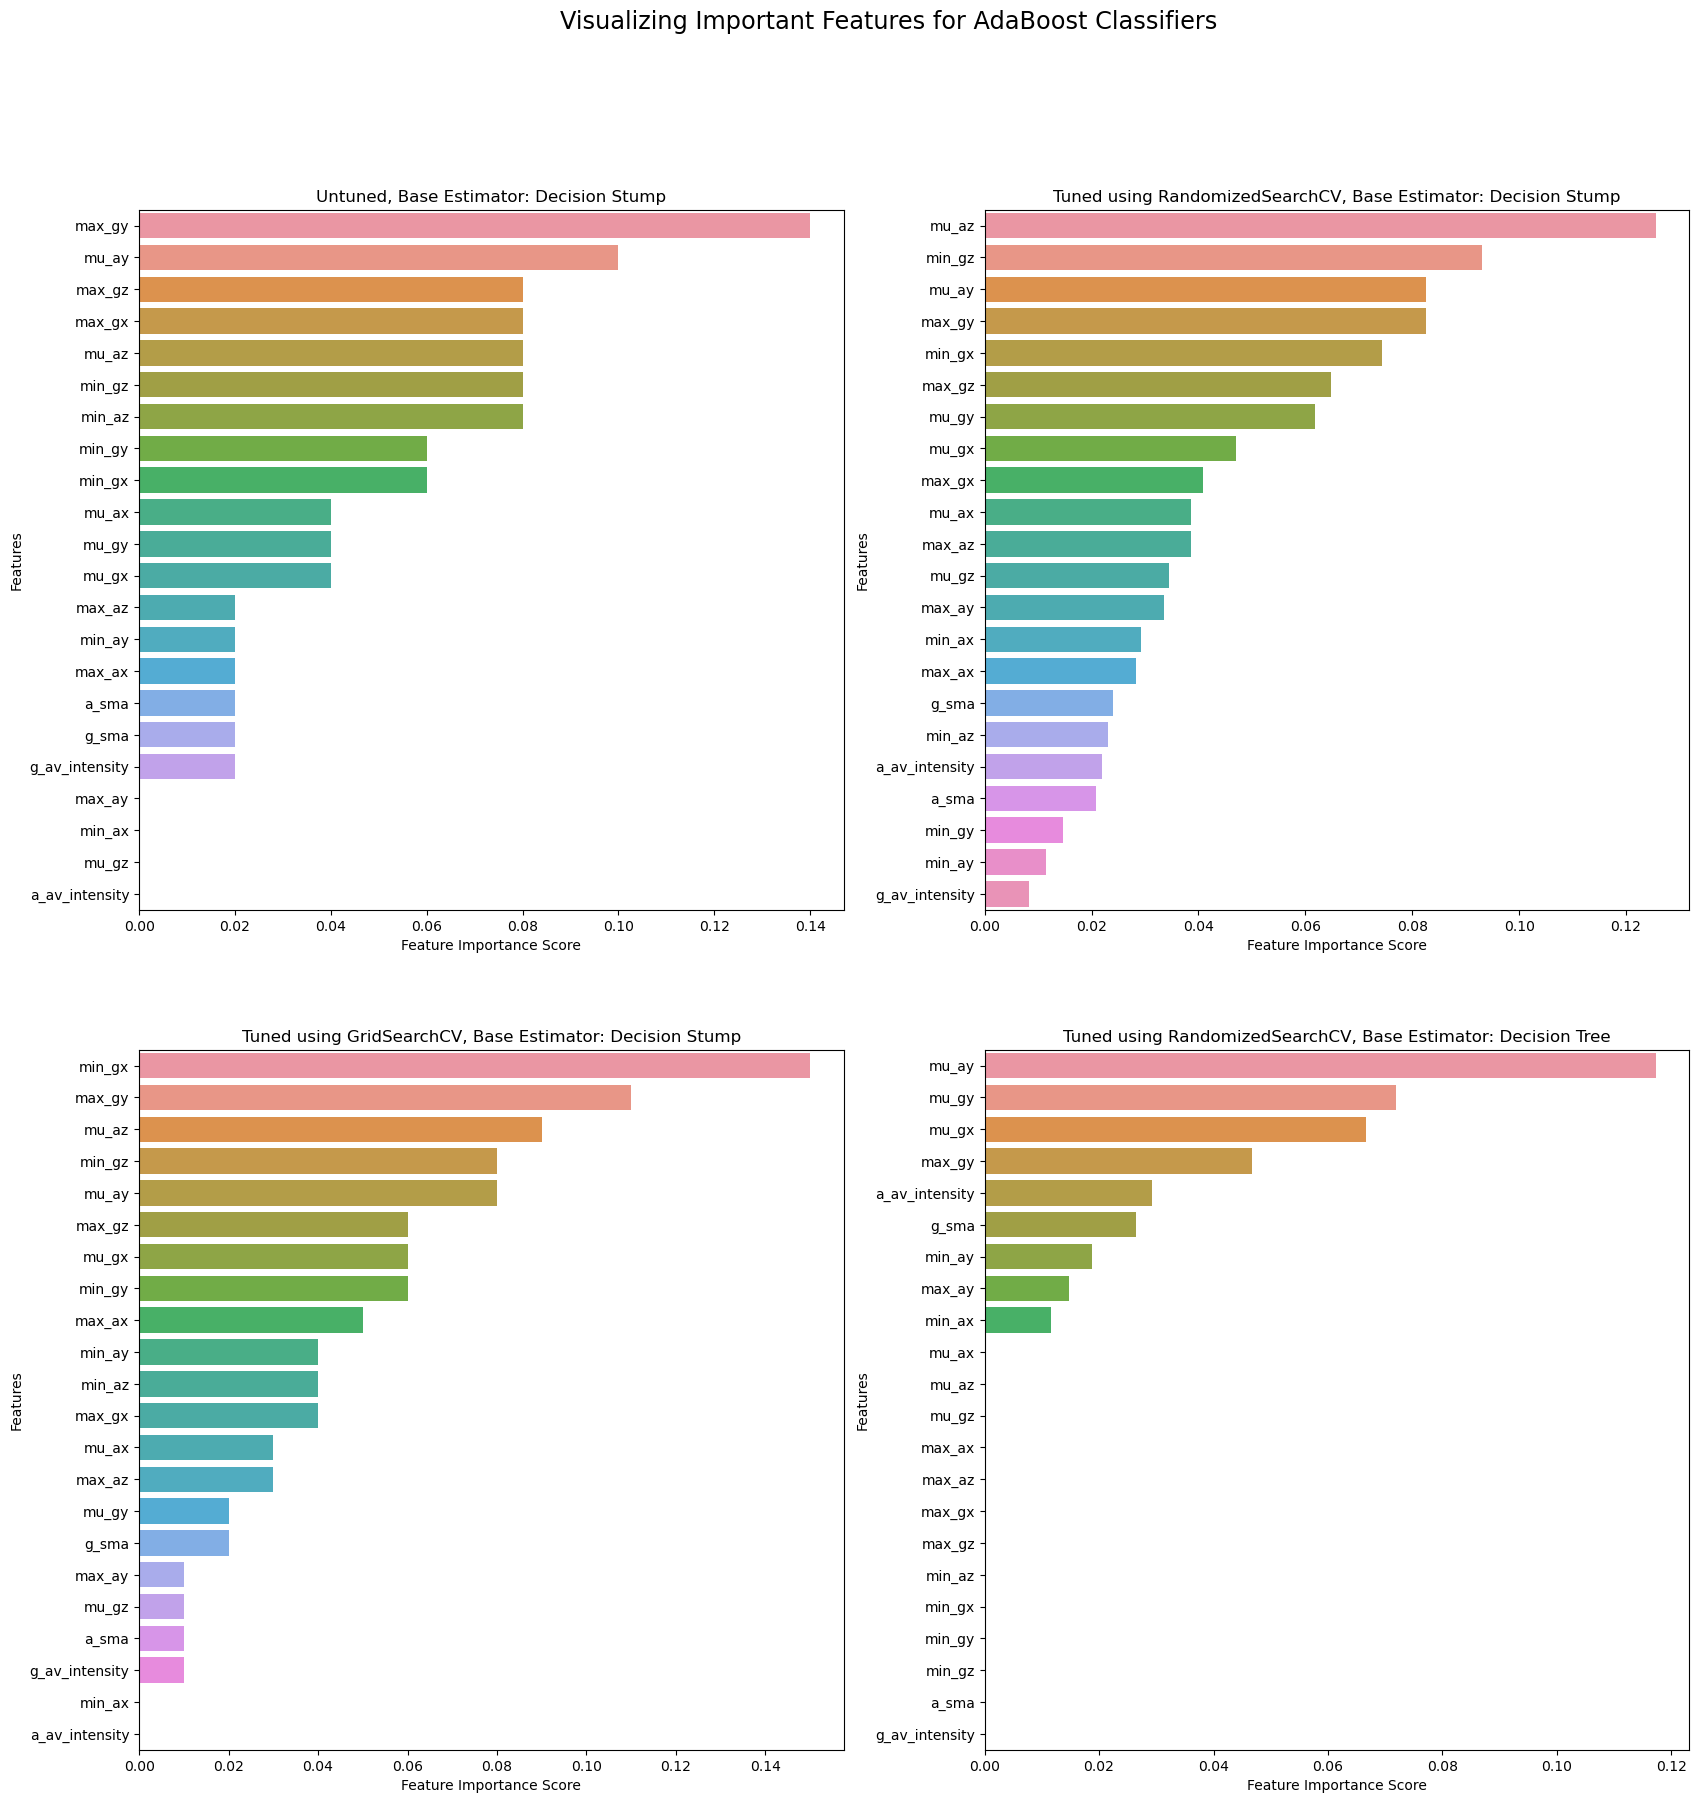

In [91]:
# Create visualizations of feature importances
def series(model):
    data = pd.Series(model.feature_importances_, index=feature_labels_copy).sort_values(ascending=False)
    return data

imp_ds_ut = series(ds_ut)
imp_ds_rand = series(best_ds_rand)
imp_ds_grid = series(best_ds_grid)
imp_dt_rand = series(best_dt_rand)

fig, ax = plt.subplots(2, 2, figsize = (20,20))
fig.suptitle("Visualizing Important Features for AdaBoost Classifiers", size="xx-large")

sns.barplot(ax=ax[0,0], x=imp_ds_ut, y=imp_ds_ut.index)
sns.barplot(ax=ax[0,1], x=imp_ds_rand, y=imp_ds_rand.index)
sns.barplot(ax=ax[1,0], x=imp_ds_grid, y=imp_ds_grid.index)
sns.barplot(ax=ax[1,1], x=imp_dt_rand, y=imp_dt_rand.index)

plt.setp(ax[:,:], xlabel = "Feature Importance Score")
plt.setp(ax[:,:], ylabel = "Features")
plt.setp(ax[0,0], title = "Untuned, Base Estimator: Decision Stump")
plt.setp(ax[0,1], title = "Tuned using RandomizedSearchCV, Base Estimator: Decision Stump")
plt.setp(ax[1,0], title = "Tuned using GridSearchCV, Base Estimator: Decision Stump")
plt.setp(ax[1,1], title = "Tuned using RandomizedSearchCV, Base Estimator: Decision Tree")


### Additional Visual - Permutation Importances
As an extra visual for my section, I’ve added in the concept of Permutation Importance. The way it differs from feature importance is that rather than assigning a score to a feature that indicates its importance in making predictions, it estimates the reduction in accuracy of a model when the data of any one feature is shuffled. The magnitude of the reduction in accuracy score when noise is introduced from this shuffle determines the importance of the feature that had the data shuffled. Tables and boxplots are provided to aid in visualizing the permutation importances.

In [90]:
# Permutation Importance tables
def perm_table(model):
    obj = PermutationImportance(model).fit(X_test, y_test)
    visual = display(eli5.show_weights(obj, feature_names = feature_labels_copy, top=None))
    return visual

# Display tables of permutation importances
print("Permutation Importance tables for AdaBoost Classifiers")
print("\nUntuned, Base Estimator: Decision Stump")
perm_table(ds_ut)
print("\nTuned using RandomizedSearchCV, Base Estimator: Decision Stump")
perm_table(ds_rand)
print("\nTuned using GridSearchCV, Base Estimator: Decision Stump")
perm_table(ds_grid)
print("\nTuned using RandomizedSearchCV, Base Estimator: Decision Tree")
perm_table(dt_rand)


Permutation Importance tables for AdaBoost Classifiers

Untuned, Base Estimator: Decision Stump



Tuned using RandomizedSearchCV, Base Estimator: Decision Stump



Tuned using GridSearchCV, Base Estimator: Decision Stump



Tuned using RandomizedSearchCV, Base Estimator: Decision Tree


[Text(0.5, 1.0, 'Tuned using RandomizedSearchCV, Base Estimator: Decision Tree')]

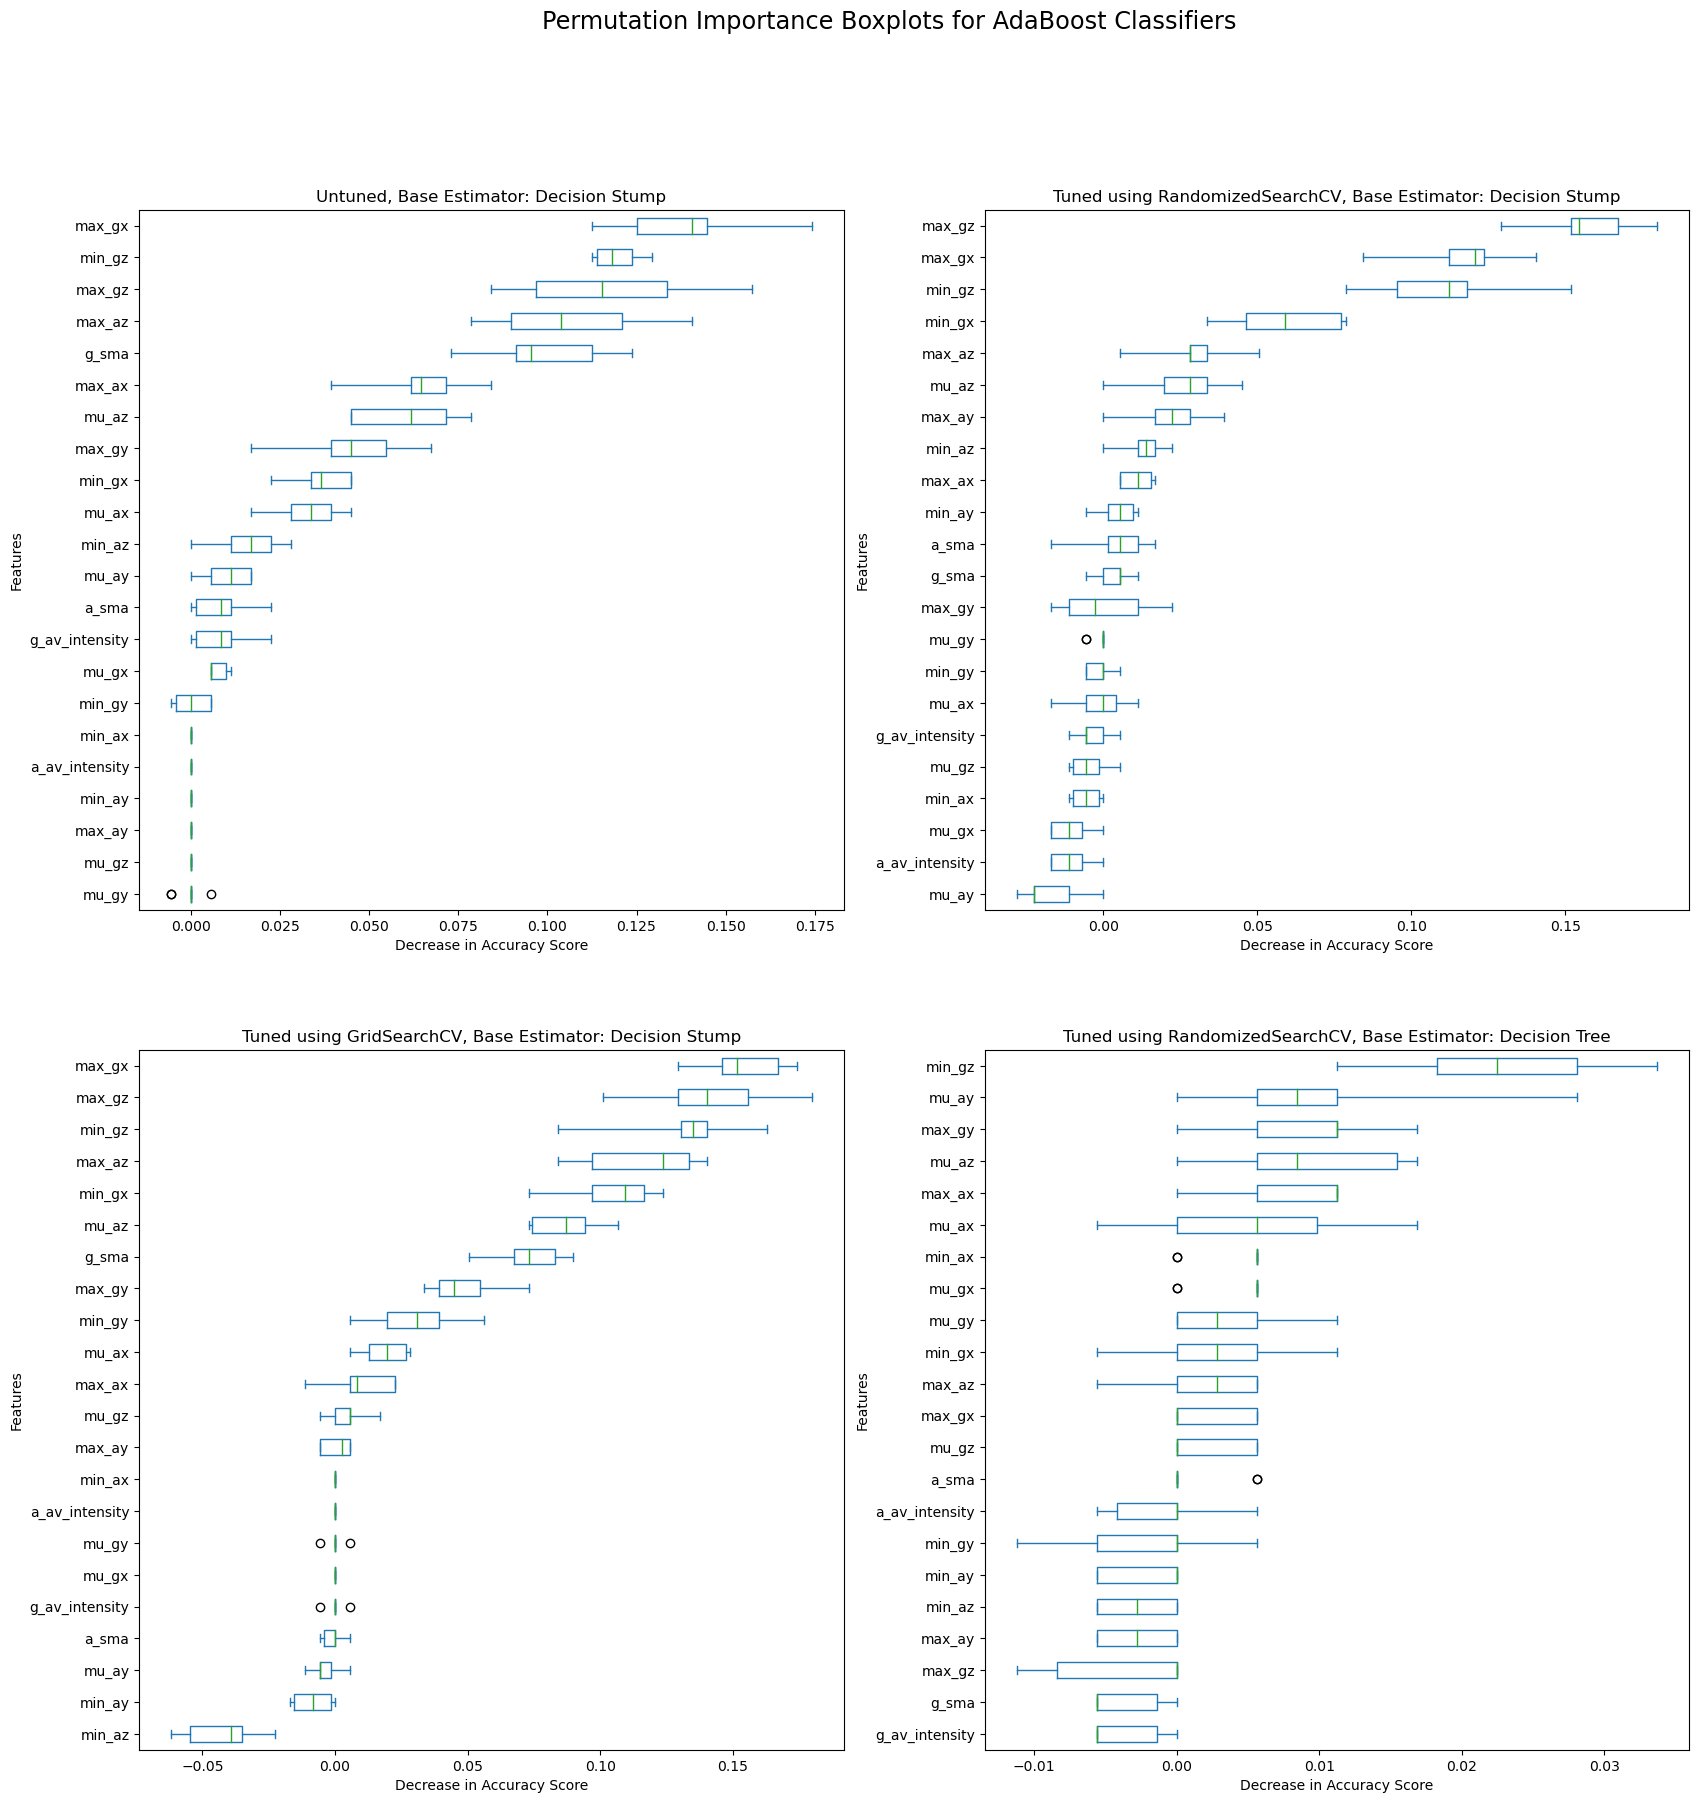

In [92]:
# Permutation Importance plots
label_array = np.array(feature_labels_copy)

def perm_imp(model,array):
    pi = permutation_importance(model, X_test, y_test, n_repeats=10, scoring="accuracy")
    sort_imp = pi.importances_mean.argsort()
    df = pd.DataFrame(pi.importances[sort_imp].T, columns=array[sort_imp])
    return df

imp_ut_df = perm_imp(ds_ut,label_array)
imp_ds_rand_df = perm_imp(ds_rand,label_array)
imp_ds_grid_df = perm_imp(ds_grid,label_array)
imp_dt_rand_df = perm_imp(dt_rand,label_array)

fig, ax = plt.subplots(2, 2, figsize = (20,20))
fig.suptitle("Permutation Importance Boxplots for AdaBoost Classifiers", size="xx-large")

imp_ut_df.plot.box(ax=ax[0][0], vert=False, whis=10)
imp_ds_rand_df.plot.box(ax=ax[0][1], vert=False, whis=10)
imp_ds_grid_df.plot.box(ax=ax[1][0], vert=False, whis=10)
imp_dt_rand_df.plot.box(ax=ax[1][1], vert=False, whis=10)

plt.setp(ax[:,:], xlabel = "Decrease in Accuracy Score")
plt.setp(ax[:,:], ylabel = "Features")
plt.setp(ax[0,0], title = "Untuned, Base Estimator: Decision Stump")
plt.setp(ax[0,1], title = "Tuned using RandomizedSearchCV, Base Estimator: Decision Stump")
plt.setp(ax[1,0], title = "Tuned using GridSearchCV, Base Estimator: Decision Stump")
plt.setp(ax[1,1], title = "Tuned using RandomizedSearchCV, Base Estimator: Decision Tree")


# Comparing results: TODO

- Random Forrest
- AdaBoost Classifier (**KIM**)
- Other other classifier (**BEAU**)

# Conclusion: TOOD